# <Center> Introduction to Data Visualisation & Exploration (COMS4060A)
# <Center> Assignment 1
### Group Members: 
Joshua Wacks - 2143116 <br>
Matthew Dacre - 2091295 <br>
Alex Vogt - 2152320 <br>
Sonia Bullah - 2107762

The following imported libraries will be used in the code:

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import missingno
import warnings
warnings.filterwarnings('ignore')
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 1. Data Cleaning
## 1.1. Date Fields:

In [47]:
# Question 1.2.3.

def convert_floats(x):
	x = x.replace(',','')
	try:
		return float(x)
	except:
		return None
		
# Question 1.1.3.

def convert_dates(x):
	return pd.to_datetime(x,format='%b %d %Y',errors = 'coerce')
        
file_name = 'logbook_assignment1.csv'

df = pd.read_csv(file_name, converters={"date_fueled":convert_dates,"date_captured": convert_dates,
                                        "odometer":convert_floats,"gallons":convert_floats,"mpg":convert_floats,"miles":convert_floats})

print(df.head())

  date_fueled date_captured  odometer  gallons cost_per_gallon total_spent  \
0         NaT    2022-04-07   73370.0      NaN             NaN         NaN   
1  2012-11-07    2016-08-30   11983.0   12.120          $5.599      $67.86   
2  2012-09-22    2012-09-28   98233.0    7.991           £5.45      £43.53   
3  2019-05-04    2019-05-04  163802.0   10.575           £5.11      £54.00   
4  2022-02-15    2022-02-15       NaN   11.651          $3.029      $35.29   

    mpg  miles                                           user_url  
0   NaN    NaN  https://www.somewebsite.com/suzuki/swift/2015/...  
1  31.6    NaN     https://www.somewebsite.com/bmw/x3/2009/461150  
2  28.5    NaN  https://www.somewebsite.com/mercedes-benz/e300...  
3  46.8    NaN   https://www.somewebsite.com/bmw/320d/2010/247233  
4  21.0  244.4  https://www.somewebsite.com/honda/passport/201...  


### Question 1.1.1.
The number of invalid dates is calculated by taking the number of null values in the *date_fueled* column. The date value is null if it failed the date conversion above.

In [48]:
# Question 1.1.1.

num_invalid_date_fueled = pd.isnull(df.date_fueled).sum()
percentage_invalid_date_fueled = num_invalid_date_fueled/len(df) *100
print("The number of invalid date fueled fields:",num_invalid_date_fueled)
print("The percentage of invalid date fueled fields:",percentage_invalid_date_fueled,"%")

The number of invalid date fueled fields: 137210
The percentage of invalid date fueled fields: 11.678738924306518 %


### Question 1.1.2.
Criteria determines the rows where date fueled is invalid and date captured is not. We then replace *date_fueled* with *date_captured* where this criteria is met.

In [49]:
# Question 1.1.2.

criteria =  np.isnat(df.date_fueled) & (~np.isnat(df.date_captured))
df.date_fueled = np.where(criteria,df.date_captured,df.date_fueled)
print(df.head())

  date_fueled date_captured  odometer  gallons cost_per_gallon total_spent  \
0  2022-04-07    2022-04-07   73370.0      NaN             NaN         NaN   
1  2012-11-07    2016-08-30   11983.0   12.120          $5.599      $67.86   
2  2012-09-22    2012-09-28   98233.0    7.991           £5.45      £43.53   
3  2019-05-04    2019-05-04  163802.0   10.575           £5.11      £54.00   
4  2022-02-15    2022-02-15       NaN   11.651          $3.029      $35.29   

    mpg  miles                                           user_url  
0   NaN    NaN  https://www.somewebsite.com/suzuki/swift/2015/...  
1  31.6    NaN     https://www.somewebsite.com/bmw/x3/2009/461150  
2  28.5    NaN  https://www.somewebsite.com/mercedes-benz/e300...  
3  46.8    NaN   https://www.somewebsite.com/bmw/320d/2010/247233  
4  21.0  244.4  https://www.somewebsite.com/honda/passport/201...  


### Question 1.1.4.
Here, we first find the records that either occur before 2005 or that are in the future relative to the current date. Then, we remove these rows from the dataframe.

In [50]:
# Question 1.1.4.

past = pd.Timestamp('20050101 00:00:00')
now = pd.Timestamp('today')
condition = df.index[((df['date_fueled'] < past) | (df['date_captured'] < past) |  (df['date_fueled'] > now) | (df['date_captured'] > now))]
num_dates = len(condition)
print("The number of invalid dates:",num_dates)

df.drop(condition,inplace=True)

The number of invalid dates: 583


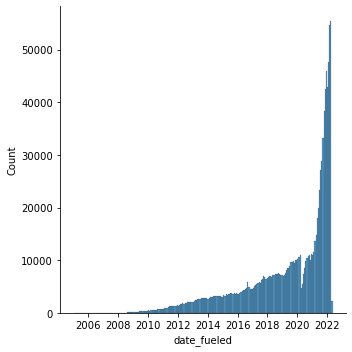

In [51]:
# Question 1.1.5.

sns.displot(df.date_fueled)

From the distribution plotted above, we can see that the number of people using this service while fueling has increased exponentially over the past few years, which is most likely due to the fact that the service provided by the company is a fairly new service and has gained more popularity over the past few years as well as that the number of people driving has increased with the overall increase in population. It can be seen that there was a significant drop in fueling dates within the first few months of 2020. This is most likely an effect of the COVID-19 pandemic, which heavily impacted the fuel industry as many countries went into severe lockdowns, resulting in a decline in fuel sales. This is because people had to work remotely and their travelling became minimal, hence the demand for fuel decreased. However, the fueling dates began increasing again after the initial shock of the pandemic. Another drop in fueling dates can be seen in 2022, which could be due to the drastic increase in fuel prices, leaving customers cautious of their spending. 

## 1.2. Numeric Fields:

In [52]:
# Question 1.2.1.

print("An overall look at the missing values","\n",df.isna().sum(),'\n')

num_missing_gallons = df['gallons'].isnull().sum()
print('Number missing gallons',num_missing_gallons)
print("Percentage of missing gallons",num_missing_gallons/len(df)* 100,'%\n')

num_missing_miles = df['miles'].isnull().sum()
print('Number missing miles',num_missing_miles)
print("Percentage of missing miles",num_missing_miles/len(df)* 100,'%\n')

num_missing_odometer = df['odometer'].isnull().sum()
print("Number missing odometer",num_missing_odometer)
print("Percentage of missing odometer",num_missing_odometer/len(df)* 100,'%\n')

other_nan = df.drop(['date_fueled', 'date_captured', 'cost_per_gallon', 'total_spent', 'mpg', 'user_url'], axis=1).isna().all(1)
chosen_notna = df[['date_fueled', 'date_captured', 'cost_per_gallon', 'total_spent', 'mpg', 'user_url']].notna().any(1)

num_missing_every = len(df[other_nan& chosen_notna])

print("Num missing all three",num_missing_every)
print("Percentage of entries missing every of the fields",num_missing_every/len(df)* 100)


An overall look at the missing values 
 date_fueled              0
date_captured            0
odometer            149034
gallons              74166
cost_per_gallon      80714
total_spent          74166
mpg                  74166
miles              1028133
user_url                 0
dtype: int64 

Number missing gallons 74166
Percentage of missing gallons 6.315832500913319 %

Number missing miles 1028133
Percentage of missing miles 87.55380924765412 %

Number missing odometer 149034
Percentage of missing odometer 12.69144595827085 %

Num missing all three 1375
Percentage of entries missing every of the fields 0.1170923292176444


### Question 1.2.2.
Since the following three columns are interdependent, we can calculate the missing value in one column given that the other two columns do not contain any missing columns. We know that:
1. miles per gallon (mpg) = $ \frac{miles}{gallon} $ <br>
2. number of gallons = $ \frac{miles}{mpg} $ <br> 
3. number of miles = $ gallons \times mpg $

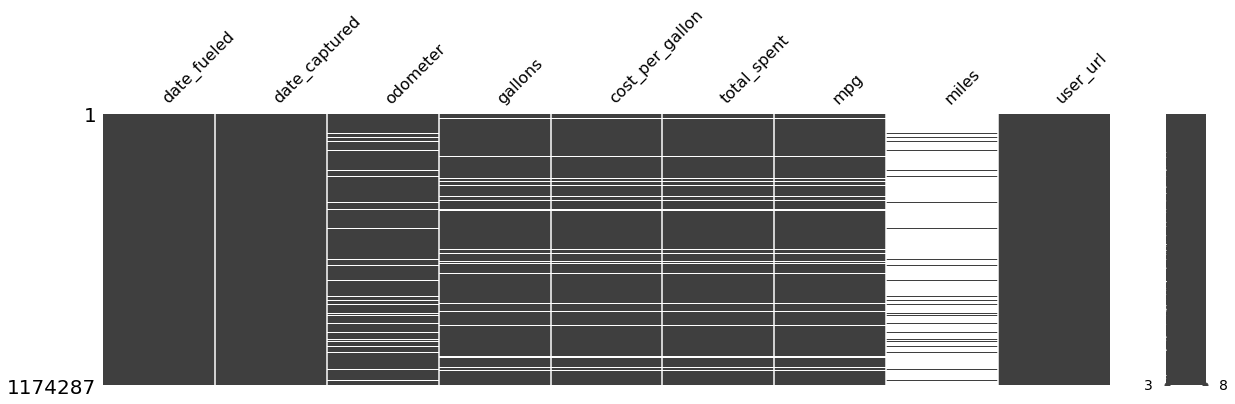

In [53]:
v = missingno.matrix(df,figsize=(20,5)) #matrix shows missing values
# Showing the missing values in the dataframe

  date_fueled date_captured  odometer  gallons cost_per_gallon total_spent  \
0  2022-04-07    2022-04-07   73370.0      NaN             NaN         NaN   
1  2012-11-07    2016-08-30   11983.0   12.120          $5.599      $67.86   
2  2012-09-22    2012-09-28   98233.0    7.991           £5.45      £43.53   
3  2019-05-04    2019-05-04  163802.0   10.575           £5.11      £54.00   
4  2022-02-15    2022-02-15       NaN   11.651          $3.029      $35.29   

    mpg     miles                                           user_url  
0   NaN       NaN  https://www.somewebsite.com/suzuki/swift/2015/...  
1  31.6  382.9920     https://www.somewebsite.com/bmw/x3/2009/461150  
2  28.5  227.7435  https://www.somewebsite.com/mercedes-benz/e300...  
3  46.8  494.9100   https://www.somewebsite.com/bmw/320d/2010/247233  
4  21.0  244.4000  https://www.somewebsite.com/honda/passport/201...   


date_fueled             0
date_captured           0
odometer           149034
gallons             7416

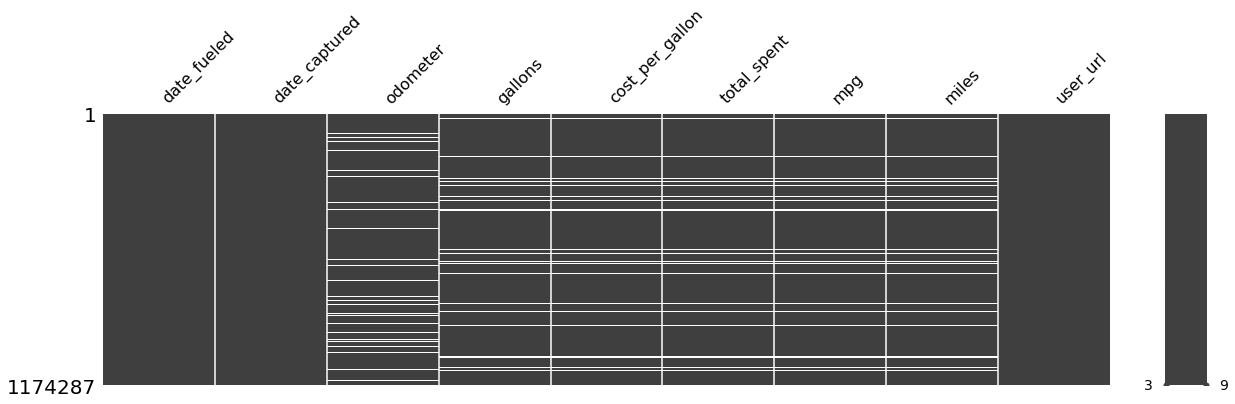

In [54]:
# Question 1.2.2.

df['mpg'] = np.where(((df['gallons'].notnull()) & (df['miles'].notnull()) & (df['mpg'].isnull())), df['miles']/df['gallons'], df['mpg'])
df['gallons'] = np.where(((df['mpg'].notnull()) & (df['miles'].notnull()) & (df['gallons'].isnull())), df['miles']/df['mpg'], df['gallons'])
df['miles'] = np.where(((df['gallons'].notnull()) & (df['mpg'].notnull()) & (df['miles'].isnull())), df['gallons'] * df['mpg'], df['miles'])

print(df.head(),'\n\n')

print(df.isna().sum(),'\n\n')

v = missingno.matrix(df,figsize=(20,5)) #matrix shows missing values

As shown in the plot above, you can see that we have filled in missing values with calculated values and thus reduced the number of missing values.

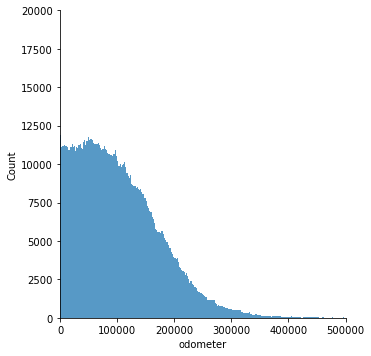

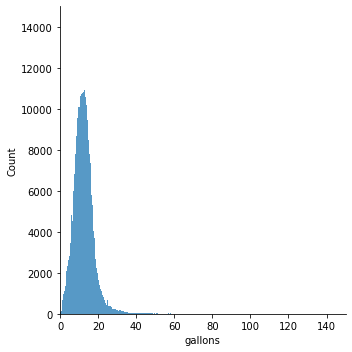

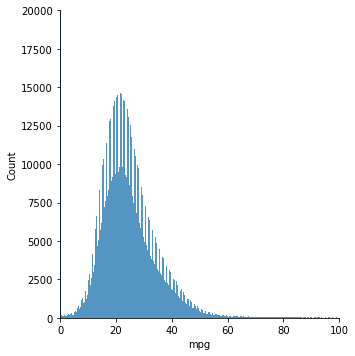

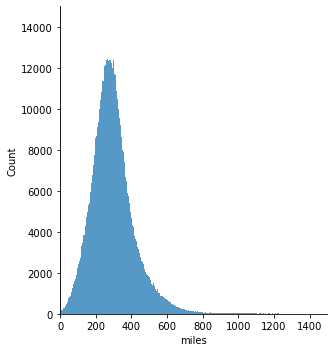

In [55]:
# Question 1.2.4.

def run_plots():
    figOdo = sns.displot(df.odometer[df.odometer.notnull()])
    figOdo.set(xlim=(0, 500000), ylim=(0, 20000))
    figGal = sns.displot(df.gallons[df.gallons.notnull()])
    figGal.set(xlim=(0, 150), ylim=(0, 15000))
    figMpg = sns.displot(df.mpg[df.mpg.notnull()])
    figMpg.set(xlim = (0,100), ylim = (0,20000))
    figMil = sns.displot(df.miles[df.miles.notnull()])
    figMil.set(xlim=(0, 1500), ylim=(0, 15000))

run_plots()

In [56]:
# Question 1.2.5.

# Getting the descriptive statistics for numerical data only:
df.describe()

,odometer,gallons,mpg,miles
count,1.025253e+06,1.100121e+06,1.100121e+06,1.100121e+06
mean,1.040014e+05,1.279742e+01,2.216306e+01,2.694540e+02
std,3.405993e+05,7.448306e+01,1.574440e+01,7.257661e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.592400e+04,8.990000e+00,1.560000e+01,1.814000e+02
50%,9.188800e+04,1.195400e+01,2.180000e+01,2.670486e+02
75%,1.469260e+05,1.493900e+01,2.850000e+01,3.427644e+02
max,2.543621e+08,2.838000e+04,1.214300e+03,1.953212e+05


At first glace, these results do not make sense as a few columns contain 0 values. It is not feasible for the minimum number of gallons, miles and miles per gallon to be zero as this dataset contains fuel logs and if a client has logged a refuel, the number of gallons, miles and miles per gallon should definitely be greater than zero. This is clearly an issue so we can look further into exactly how many invalid zeros are found in each column.

In [57]:
print((df[['odometer', 'gallons', 'mpg', 'miles']] == 0).sum())

odometer        10
gallons        572
mpg         139055
miles       134750
dtype: int64


As shown above, all four columns contain missing values. The last three rows need to either be dropped or recalculated if they are interdependent columns as it does not make sense to analyse data with invalid values.

# 2. Feature Engineering

### Question 2.1. (1)
The currency symbol is extracted by taking all the characters up to the first digit.

In [58]:
# Question 2.1. (1)

def index(x):
    i = 0
    for c in x:
        if c.isdigit():
            return i
        else:
            i += 1
    return i

def extract_currency(x):
    if isinstance(x, str):
        # Takes all chars up to the first 
        return x[:index(x)]
    else:
        # If not string, such as is NaN, puts as none
        return None

df['currency'] = df['total_spent'].apply(extract_currency)


### Question 2.2. (1)
The float value is extracted by taking all characters from the first digit to the end of the string.

In [59]:
# Question 2.2. (2)

def index(x):
    i = 0
    for c in x:
        if c.isdigit():
            return i
        else:
            i += 1
    return i

def extract_float(x):
    if isinstance(x, str):
        xStripped = x.replace(',', '')
        # Takes all chars up to the first
        return float(xStripped[index(xStripped):])
    else:
        # If not string returns NaN
        return np.NaN

df['total_spent'] = df['total_spent'].apply(extract_float)
df['cost_per_gallon'] = df['cost_per_gallon'].apply(extract_float)

df.head()

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,currency
0,2022-04-07,2022-04-07,73370.0,NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,None
1,2012-11-07,2016-08-30,11983.0,12.120,5.599,67.86,31.6,382.9920,https://www.somewebsite.com/bmw/x3/2009/461150,$
2,2012-09-22,2012-09-28,98233.0,7.991,5.450,43.53,28.5,227.7435,https://www.somewebsite.com/mercedes-benz/e300...,£
3,2019-05-04,2019-05-04,163802.0,10.575,5.110,54.00,46.8,494.9100,https://www.somewebsite.com/bmw/320d/2010/247233,£
4,2022-02-15,2022-02-15,NaN,11.651,3.029,35.29,21.0,244.4000,https://www.somewebsite.com/honda/passport/201...,$


### Question 2.3. (1)
The details are extracted by splitting by the '/'. Some urls were missing details in a way that could not easily be detected and were not applicable. Therefore, they were ignored.

In [60]:
def extract_details(x):
    if len(x) < 28:
        return None, None, np.NaN, np.NaN
    x = x[27:]
    l = [i for i, letter in enumerate(x) if letter == '/']
    try:         
        car_make = x[l[0] + 1:l[1]]
        car_model = x[l[1] + 1:l[2]]
        year = x[l[2] + 1:l[3]]
        user_id = x[l[3] + 1:]
        return car_make, car_model, int(year), int(user_id)
    except:
        return None, None, np.NaN, np.NaN


df['car_make'], df['car_model'], df['year'], df['user_id'] = zip(*df['user_url'].apply(extract_details))
print(df[['car_make', 'car_model', 'year', 'user_id']].head())

        car_make car_model    year    user_id
0         suzuki     swift  2015.0   674857.0
1            bmw        x3  2009.0   461150.0
2  mercedes-benz      e300  1998.0   133501.0
3            bmw      320d  2010.0   247233.0
4          honda  passport  2019.0  1038865.0


In [61]:
# Questions 2.1. & 2.2. & 2.3. (2)

# Going to use US gallons unless given that it is british

def convert_gallon(num, curr):
    if curr == '£':
        return num*4.54609
    else:
        return num*3.785
    
def convert_cost(num, curr):
    if curr == '£':
        return num/4.54609
    else:
        return num/3.785

df['litres'] = df.apply(lambda x: convert_gallon(x['gallons'], x['currency']), axis=1)
df['km'] = df['miles']*1.60934
df['litres_per_100'] = (df['litres']/df['km'])*100
df['cost_per_litre'] = df.apply(lambda x: convert_cost(x['cost_per_gallon'], x['currency']), axis=1)
print(df[['litres', 'km', 'litres_per_100']].head())

      litres          km  litres_per_100
0        NaN         NaN             NaN
1  45.874200  616.364345        7.442708
2  36.327805  366.516724        9.911636
3  48.074902  796.478459        6.035932
4  44.099035  393.322696       11.211922


# 3. Vehicle Exploration

0          None
1             $
2             £
3             £
4             $
           ... 
1174865       $
1174866       $
1174867       $
1174868       $
1174869       $
Name: currency, Length: 1174287, dtype: object


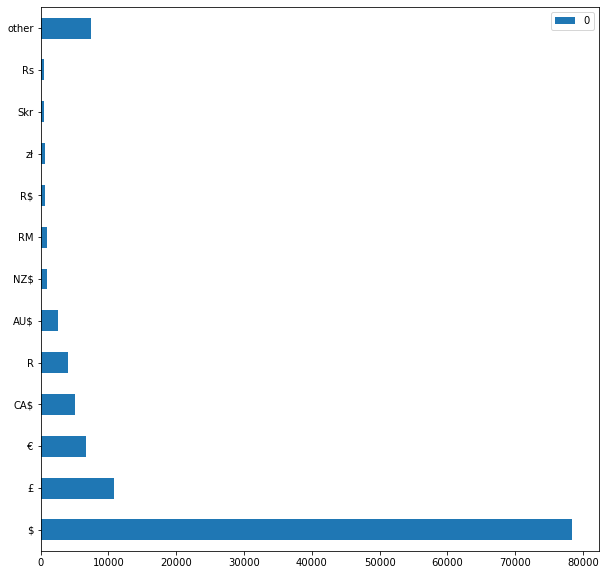

In [62]:
# Question 3.1.

data = df.groupby('currency')['user_id'].nunique().sort_values(ascending=False)
data_above_number = data[data>=500]
data_below_number = data[data<500].sum()
dfTemp = pd.DataFrame(data = [data_below_number], index =['other'])
data = pd.concat([data_above_number,dfTemp])
data.plot(figsize =(10,10),kind = 'barh')

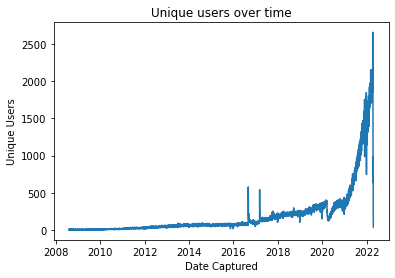

In [63]:
# Question 3.2.

# Grouping by day, finding unique users for each day
vals = df.groupby(by='date_captured', as_index=False).agg({'user_id': pd.Series.nunique})
v = sns.lineplot(x=vals['date_captured'], y=vals['user_id']).set(xlabel="Date Captured", ylabel="Unique Users", title="Unique users over time")

As shown above, there is a sharp drop on the last day. This is likely due to the data being scraped in the morning, while the total daily unique users is summated in the afternoons.

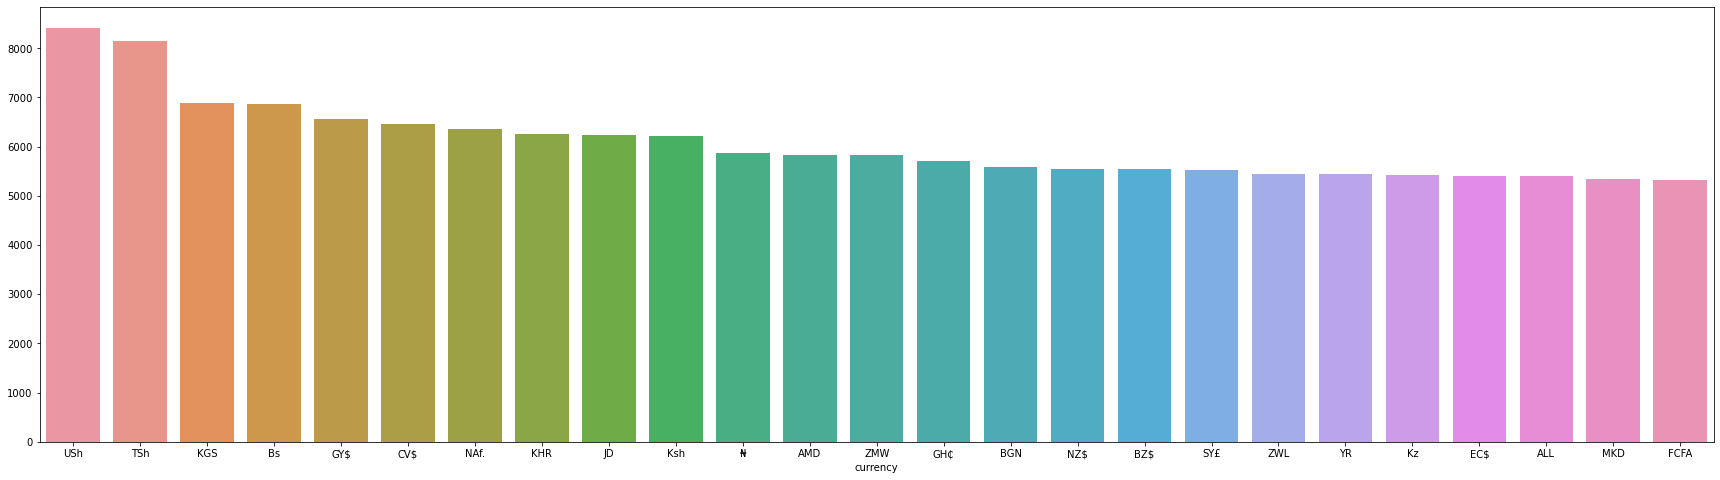

In [64]:
# Question 3.3.

import matplotlib.pyplot as plt
dfCopy = df.copy()
dfCopy['year'] = pd.to_datetime(dfCopy['year'], format='%Y')
fig, axs = plt.subplots(figsize=(30, 8))


data = dfCopy.groupby('currency').apply(lambda x: (x['date_fueled'] - x['year']).mean()).sort_values(ascending=False).head(25)
sns.barplot(x = data.index, y=data.astype('timedelta64[D]'))

plt.show()

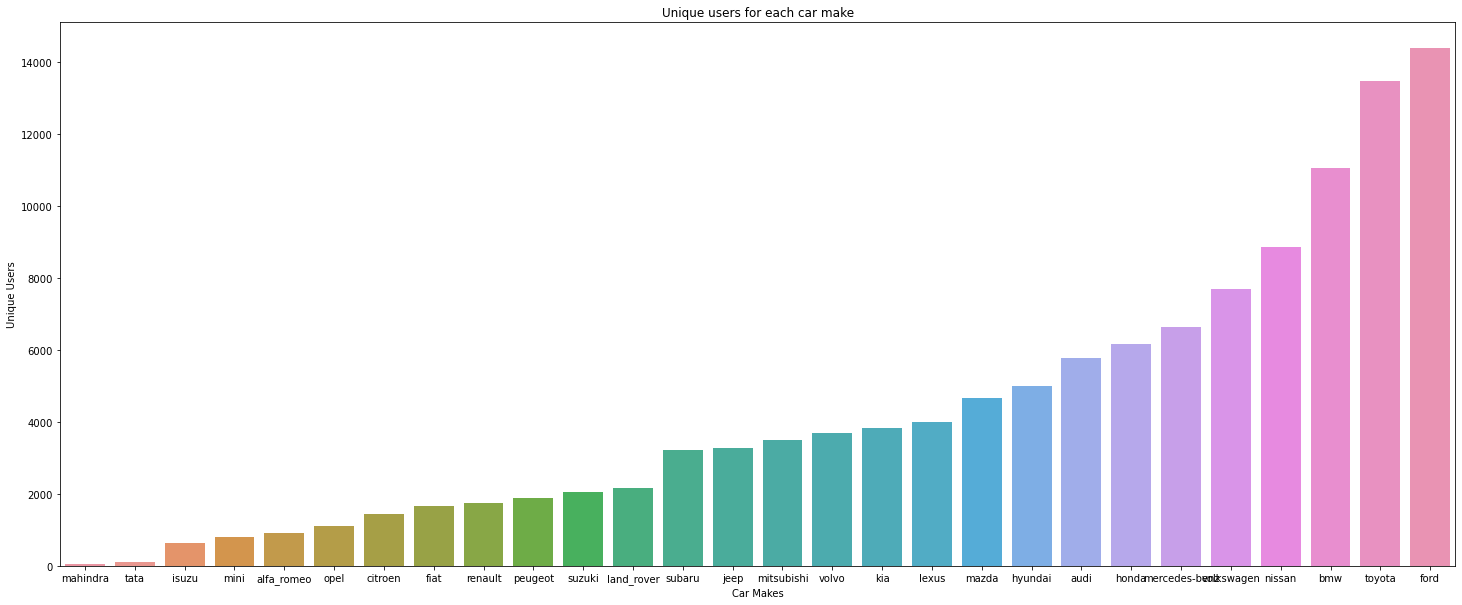

In [65]:
# Question 3.4. (1)

# Grouping by car_make, counter unique users for each make
vals = df.groupby(by='car_make', as_index=False).agg({'user_id': pd.Series.nunique}).sort_values('user_id')
fig, axs = plt.subplots(figsize=(25, 10))

sns.barplot(x=vals['car_make'], y=vals['user_id']).set(xlabel="Car Makes", ylabel="Unique Users", title="Unique users for each car make")
plt.show()

The most popular model is Ford.

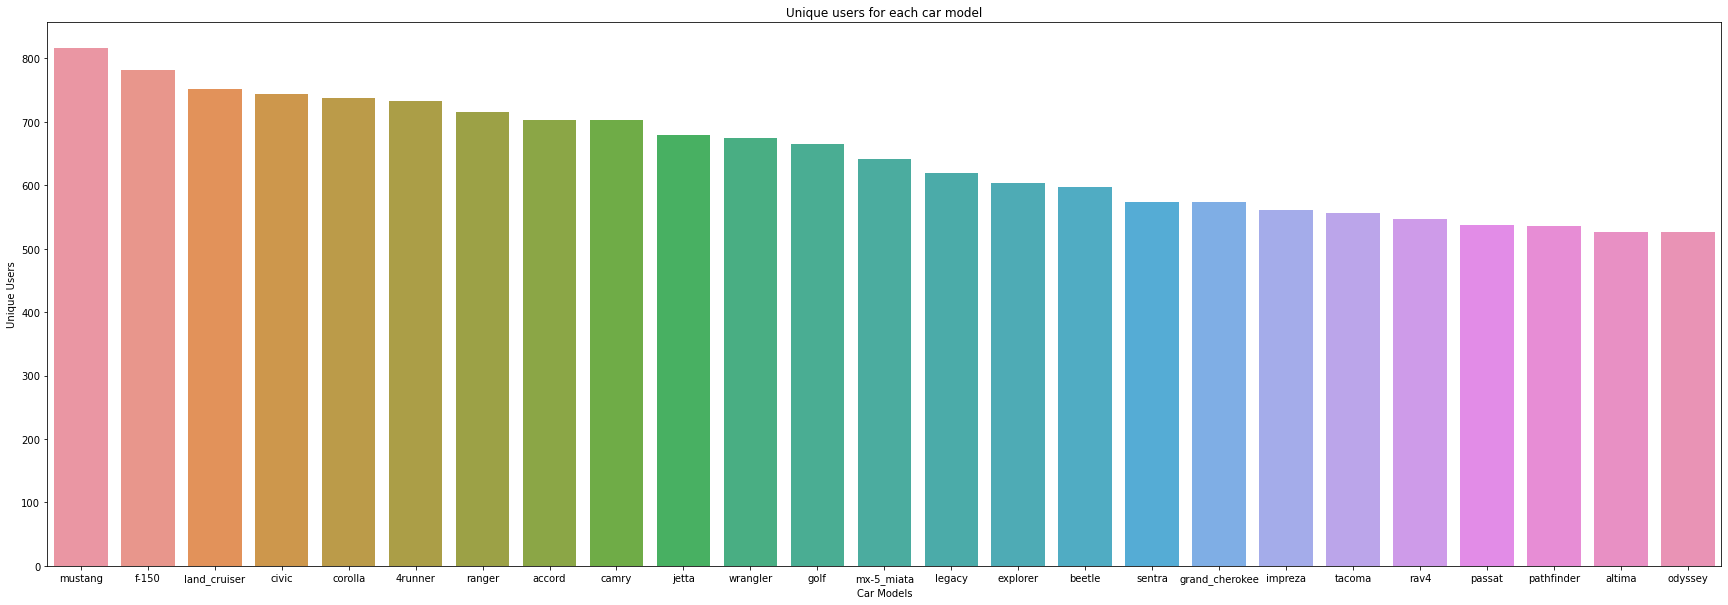

In [66]:
# Question 3.4. (2)

vals = df.groupby(by='car_model', as_index=False).agg({'user_id': pd.Series.nunique}).sort_values('user_id',ascending=False)

vals['car_model'] = np.where(vals['user_id'] >= np.min(vals['user_id'].nlargest(25)), vals['car_model'], "Other")
# Dropping other as its not relevant for this question
vals = vals[vals.car_model != "Other"]

fig, axs = plt.subplots(figsize=(30, 10))

sns.barplot(x=vals['car_model'], y=vals['user_id']).set(xlabel="Car Models", ylabel="Unique Users", title="Unique users for each car model")
plt.show()


The most popular model is the Mustang.

# 4. Fuel Usage

## 4.1. Outlier Removal

In [67]:
# Question 4.1.1.

print('The top 5 currencies are\n',df['currency'].value_counts()[0:5])
top5_currencies = df['currency'].value_counts().index.tolist()[0:5]

The top 5 currencies are
 $      741945
£       87587
€       59273
CA$     46848
R       36424
Name: currency, dtype: int64


In [68]:
def create_specific_df():
	new_df = df.loc[(df['currency'] == top5_currencies[0]) | (df['currency'] == top5_currencies[1]) | (df['currency'] == top5_currencies[2])
				| (df['currency'] == top5_currencies[3]) | (df['currency'] == top5_currencies[4])] 
 	# a new dataframe is created with only the top5 currencies
 
	cols = ['litres','cost_per_litre','total_spent'] # These are the columns we are removing outliers for

	return new_df,cols

In [69]:
top5_currency_df,feature_cols = create_specific_df()
print("The total number of records before removing outliers: ", len(top5_currency_df))

The total number of records before removing outliers:  972077


The box and whisker plots before outlier removal


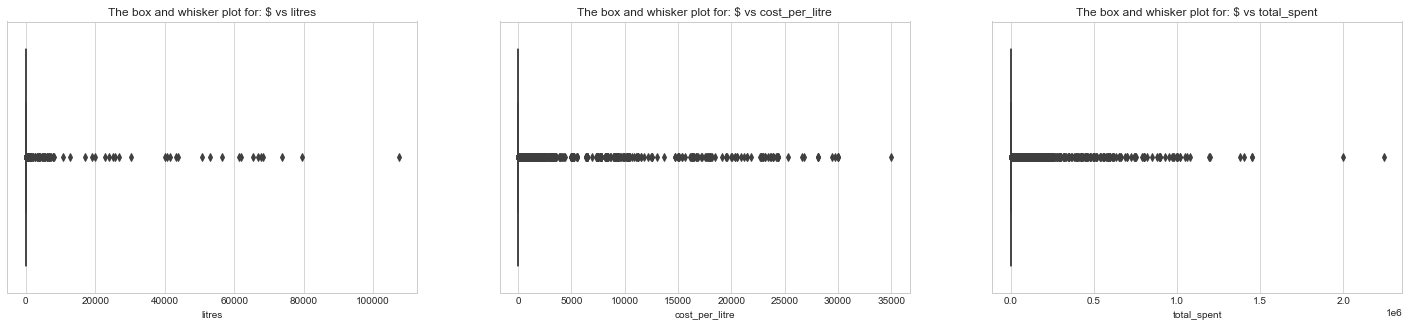

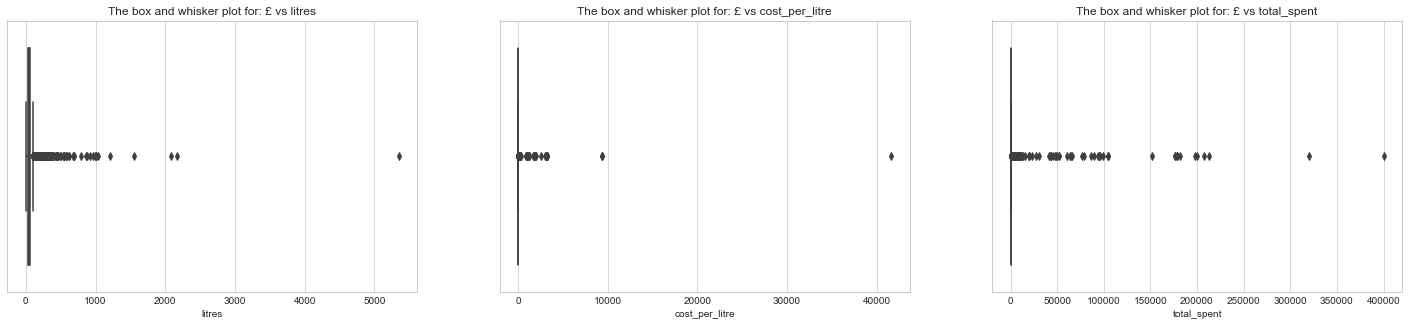

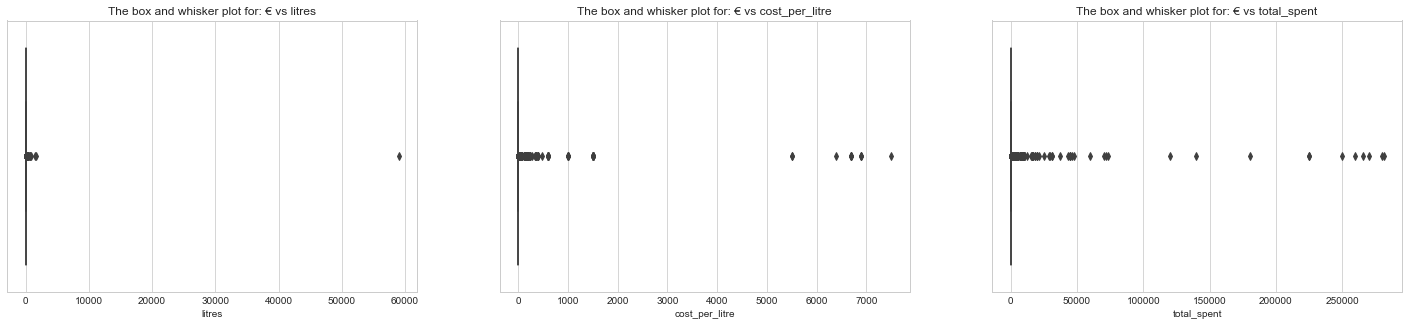

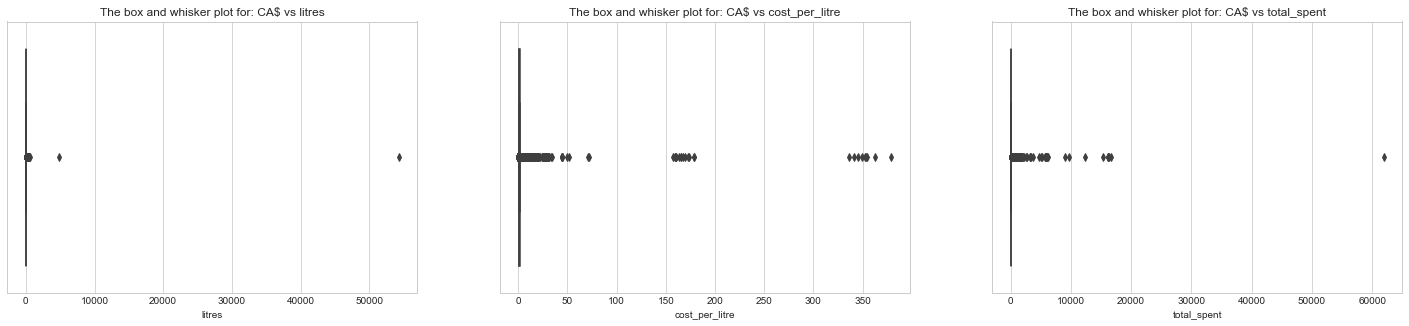

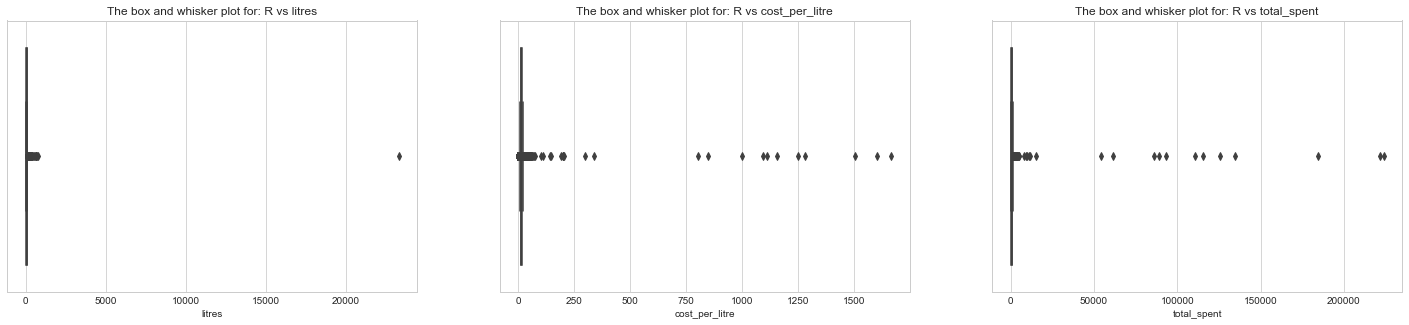

In [70]:
# Question 4.1.2.

def boxplots():
	plt.style.use('seaborn-whitegrid')
	for currency in top5_currencies:
		fig, ax = plt.subplots(1,3,figsize = (25, 5))
     
		for i,feature in enumerate(feature_cols):
			data = (top5_currency_df[feature][(top5_currency_df['currency'] == currency)])
			title = "The box and whisker plot for: " + currency + " vs " + feature
			sns.boxplot(x=data, ax=ax[i]).set(title = title)
			fig.show()

print("The box and whisker plots before outlier removal")
boxplots()

From the plots above we can see there are a large amount of outliers, that skew the data.

We consider the following cases in the outlier removal process:

- Case 1: Removing NaN values where applicable, where 2 or more of (total_spend , cost_per_litre , gallons ) == NaN

- Case 2: Replacing NaN values where we can.

- Case 3: A combination of KNN,z-score and isolation forests

- Case 4: Checking where total_spend != litres * cost_per_litre (within a given range)

In [71]:
def case1():
	for feature in feature_cols:
		top5_currency_df[feature].replace(0.0,np.nan,inplace = True)
	
	condition = top5_currency_df.index[(top5_currency_df[feature_cols[0]].isna()) & (top5_currency_df[feature_cols[1]].isna()) & (top5_currency_df[feature_cols[2]].isna())]
	top5_currency_df.drop(condition,inplace = True)
 
	condition = top5_currency_df.index[((top5_currency_df[feature_cols[0]].isna()) & (top5_currency_df[feature_cols[1]].isna()))]
	top5_currency_df.drop(condition,inplace = True)
 
	condition = top5_currency_df.index[((top5_currency_df[feature_cols[1]].isna()) & (top5_currency_df[feature_cols[2]].isna()))]
	top5_currency_df.drop(condition,inplace = True)
 
	condition = top5_currency_df.index[((top5_currency_df[feature_cols[0]].isna()) & (top5_currency_df[feature_cols[2]].isna()))]
	top5_currency_df.drop(condition,inplace = True)
 
print("The number of records before case1:",len(top5_currency_df))
loss_case1 = len(top5_currency_df)
case1()
print("The number of records before case1:",len(top5_currency_df))
loss_case1 = loss_case1 - len(top5_currency_df)
print("The total number of outliers removed due to case1: ", loss_case1)

The number of records before case1: 972077
The number of records before case1: 960139
The total number of outliers removed due to case1:  11938


In [72]:
def case2():
	top5_currency_df['litres'].fillna((top5_currency_df['total_spent']/top5_currency_df['cost_per_litre']),inplace=True)

	top5_currency_df['cost_per_litre'].fillna((top5_currency_df['total_spent']/top5_currency_df['litres']),inplace=True)
	
	top5_currency_df['total_spent'].fillna((top5_currency_df['litres'] * top5_currency_df['cost_per_litre']),inplace=True)

case2()

We decided to merge the results of Isolation Forest and KNN using intersection, then remove that intersection. This allows us to find more outliers but then cross-validate them with a secondary method. Because 2 methods are utilised, the runtime is significantly longer than if only 1 method was used.

Number of records before outlier detection:  960139


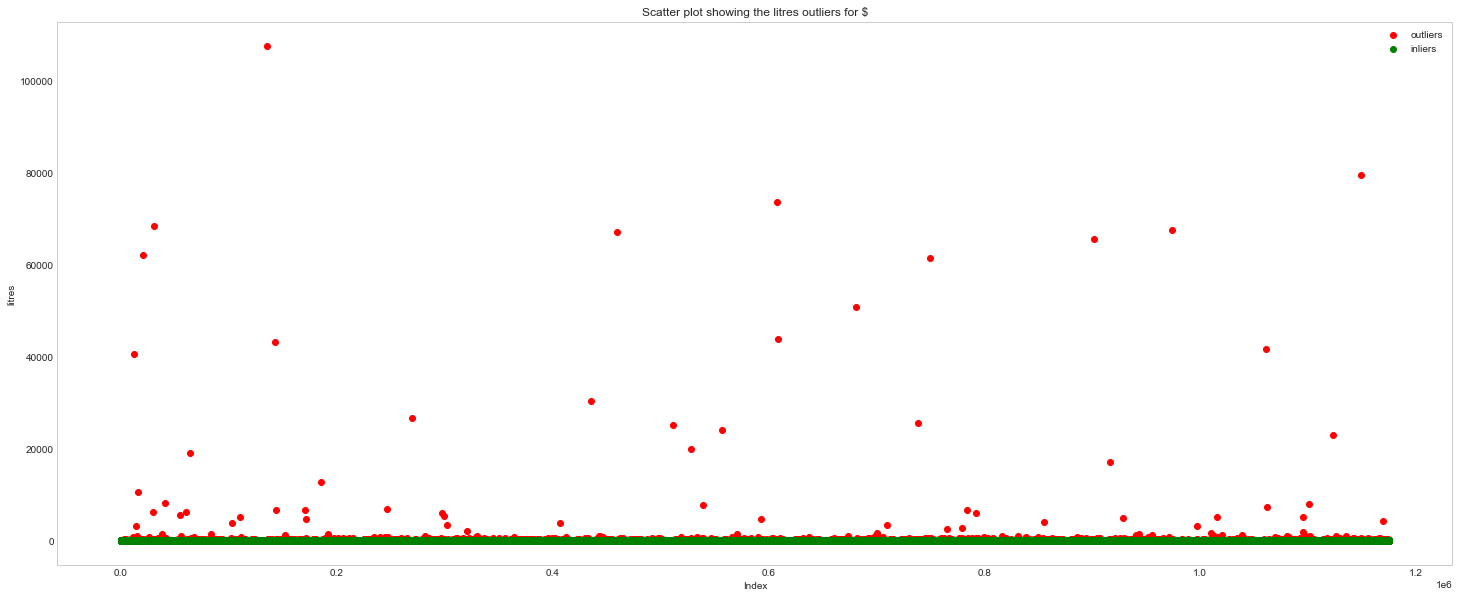

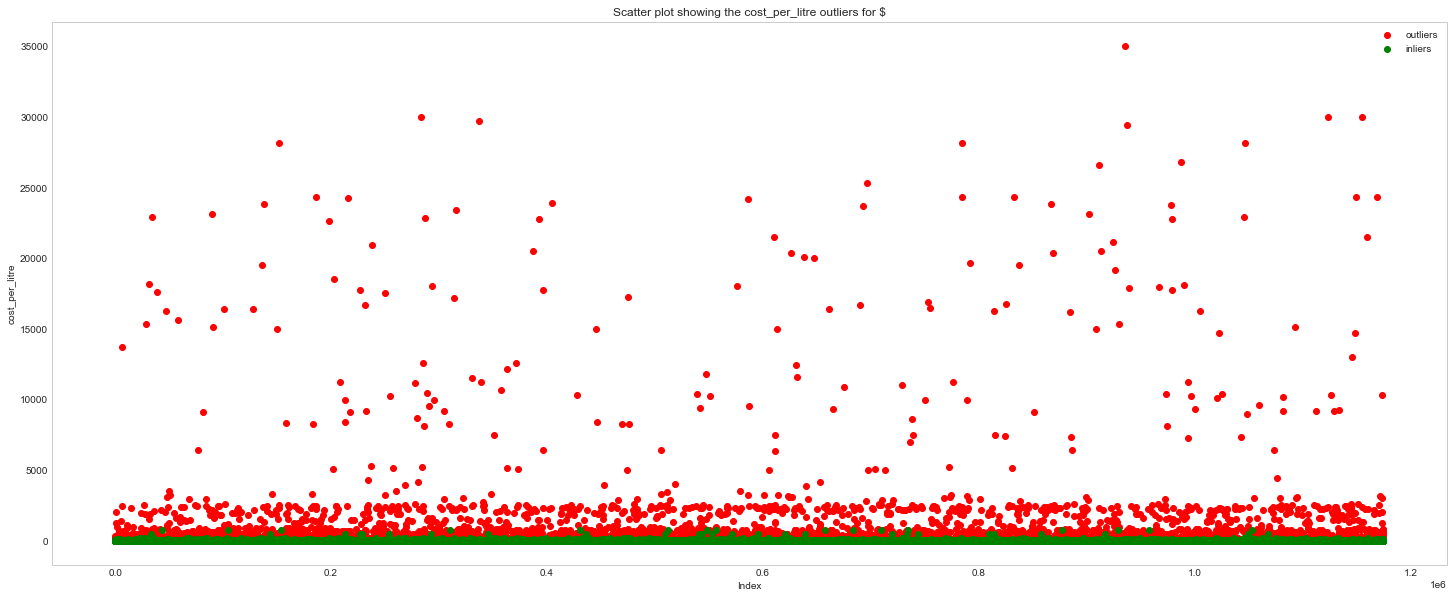

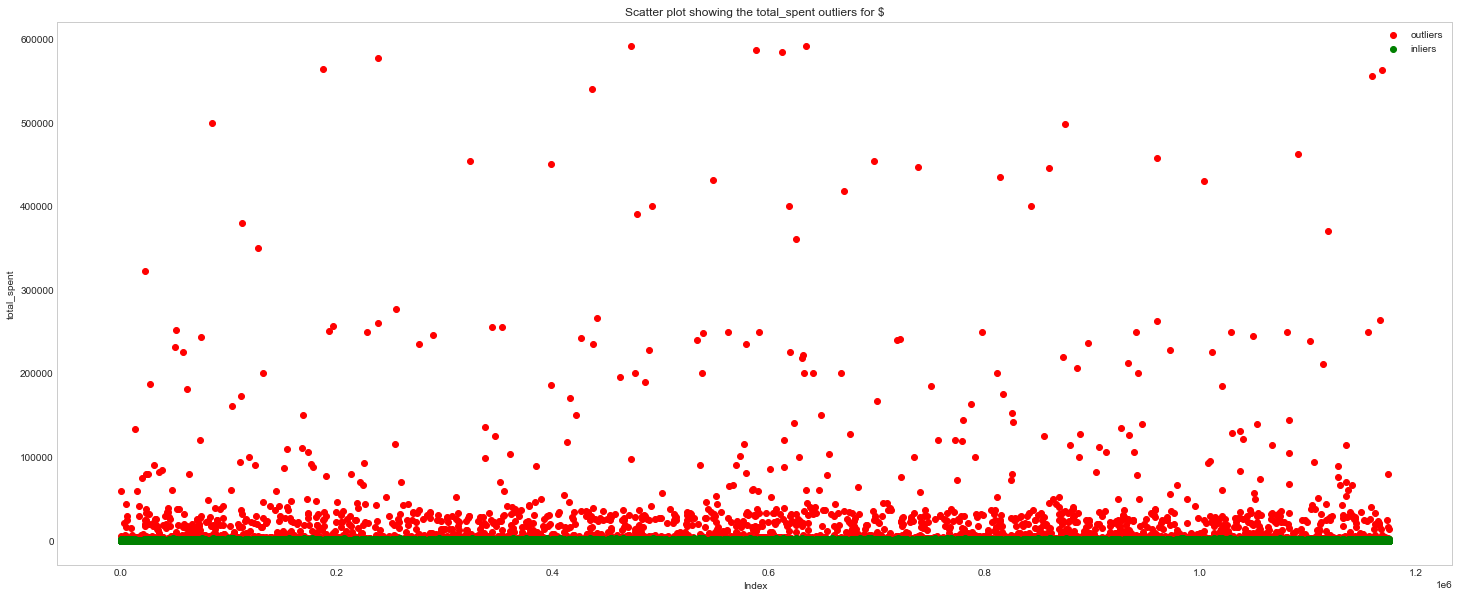

Number of records after outlier detection:  940094
The total number of outliers removed:  20045


In [73]:
def run_outlier_detection():
	contamination = 0.01
	for currency in top5_currencies:
		clf = IsolationForest( max_samples=len((top5_currency_df[top5_currency_df['currency']== currency])),contamination=contamination)
		clf2 = KNN(contamination=contamination)
		
		for feature in feature_cols:
			df_copy = top5_currency_df[top5_currency_df['currency'] == currency]
			
			data = df_copy[feature].to_numpy().reshape(-1,1)
			# Isolation Forest
			clf.fit(data)
			df_copy['anomaly'] = clf.predict(data)
			
			anomaly_index = df_copy.index[df_copy['anomaly'] == -1]
			inliear_index = df_copy.index[df_copy['anomaly'] == 1]

			#KNN
			clf2.fit(data)
			df_copy['anomaly'] = clf2.predict(data)
   
			anomaly_index2 = df_copy.index[df_copy['anomaly'] == 1]
			inliear_index2 = df_copy.index[df_copy['anomaly'] == 0]
			
						
			outlier_indices_set = list(np.intersect1d(anomaly_index,anomaly_index2))
			inlier_indices_set = list(np.intersect1d(inliear_index,inliear_index2))

			if currency == top5_currencies[0]: # Only want to plot the first currency to get an idea 
				fig, axs = plt.subplots(figsize=(25, 10))
				plt.scatter(outlier_indices_set, df_copy.loc[outlier_indices_set][feature],color='red', label='outliers')
				plt.scatter(inlier_indices_set,  df_copy.loc[inlier_indices_set][feature],color='green',label='inliers')
				plt.legend()
				plt.grid()
				plt.ylabel(feature)
				plt.xlabel('Index')
				title = 'Scatter plot showing the ' + feature + ' outliers for ' + currency
				plt.title(title)
				plt.show()
	
			top5_currency_df.drop(outlier_indices_set,inplace=True)

print("Number of records before outlier detection: ", len(top5_currency_df))
loss_caseCombo = len(top5_currency_df)
run_outlier_detection()
loss_caseCombo= loss_caseCombo - len(top5_currency_df)
print("Number of records after outlier detection: ", len(top5_currency_df))
print("The total number of outliers removed: ", loss_caseCombo)

In [74]:
def case4():
	currency_conversions = {
		top5_currencies[0] : 15.85,
		top5_currencies[1] : 19.85,
		top5_currencies[2] : 16.69,
		top5_currencies[3] : 12.34,
		top5_currencies[4] : 1
	} 

	top5_currency_df['cost_per_litre_R'] = top5_currency_df['cost_per_litre'] * top5_currency_df['currency'].map(currency_conversions)
	top5_currency_df['total_spent_R'] = top5_currency_df['total_spent'] * top5_currency_df['currency'].map(currency_conversions)
 
	threshold = 5
	temp = top5_currency_df['cost_per_litre_R'] * top5_currency_df['litres']
	condition = top5_currency_df.index[(top5_currency_df['total_spent_R'] < (temp-threshold)) | (top5_currency_df['total_spent_R'] > (temp+threshold))]
	top5_currency_df.drop(condition,inplace = True)

print(len(top5_currency_df))
loss_case4 = len(top5_currency_df)
case4()
print(len(top5_currency_df))
loss_case4 = loss_case4 - len(top5_currency_df)
print("The total number of outliers removed due to case 4: ", loss_case4)



940094
940005
The total number of outliers removed due to case 4:  89


In [75]:
def case5():
	thresholds = [8,2.5,2.5]
	for currency in top5_currencies:
		for i,feature in enumerate(feature_cols):
			df_copy = top5_currency_df[top5_currency_df['currency'] == currency]
			
			df_copy['z_score'] = stats.zscore(df_copy[feature])
			outlier_index = df_copy.index[df_copy['z_score'] > thresholds[i]]
	
			top5_currency_df.drop(outlier_index,inplace=True)

print("Number of records before z_score outlier detection: ", len(top5_currency_df))
loss_case5 = len(top5_currency_df)
case5()
loss_case5= loss_case5 - len(top5_currency_df)
print("Number of records after z_score outlier detection: ", len(top5_currency_df))
print("The total number of outliers removed: ", loss_case5)

Number of records before z_score outlier detection:  940005
Number of records after z_score outlier detection:  918881
The total number of outliers removed:  21124


These threshold values were chosen for the z-score due to the following reasons:
- **litres: 8** - as litres had a more uniform distribution and thus we had already removed most of the outliers by this point.
- **cost_per_litre and total_spent: 2.5** - these had a very skew distribution and thus we had to use a lower threshold to ensure that all the outliers were removed.
We did use trial and error to estimate these threshold values best.

The box and whisker plots after outlier removal


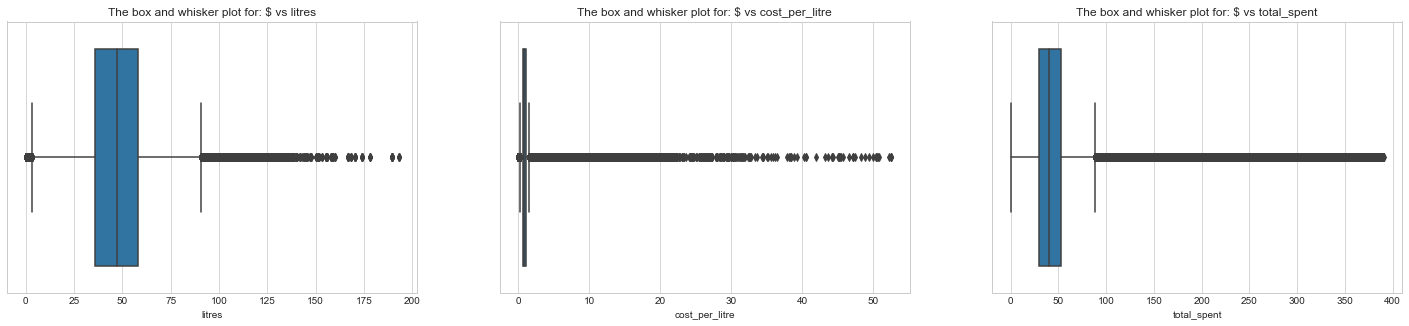

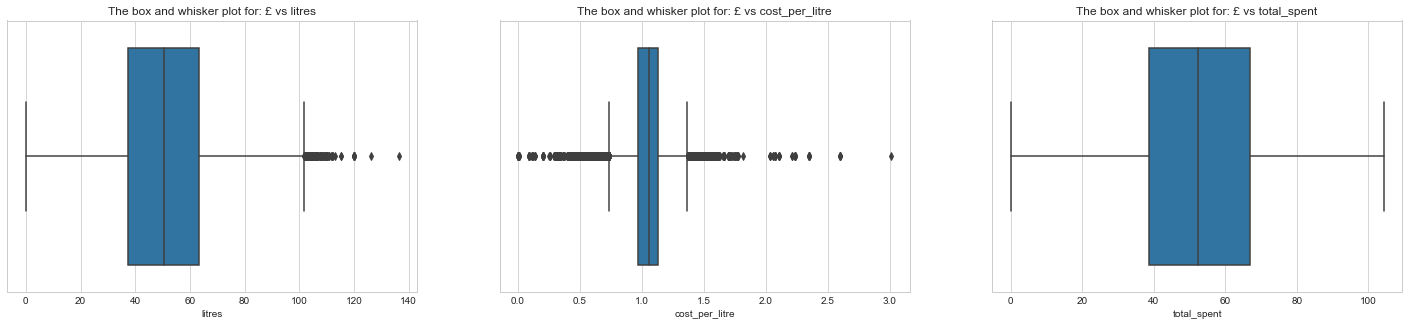

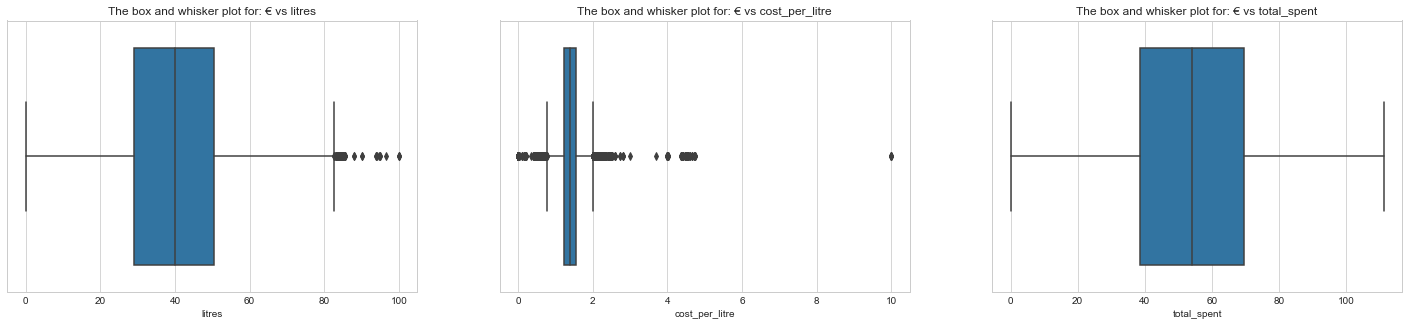

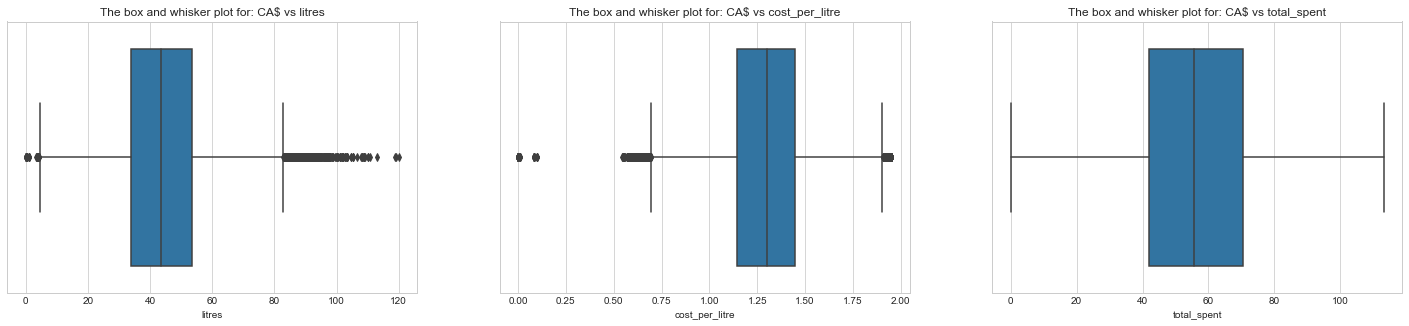

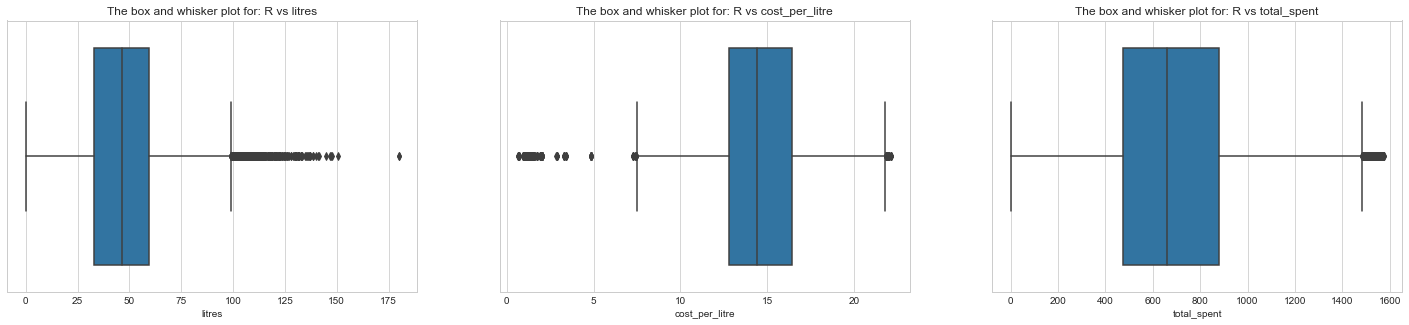

In [76]:
print("The box and whisker plots after outlier removal")
boxplots()

In [77]:
# Question 4.1.3.

total_outliers = loss_case1 + loss_caseCombo + loss_case4 + loss_case5
print("The total number of outliers removed is:",total_outliers)

The total number of outliers removed is: 53196


## 4.2. Fuel Efficiency

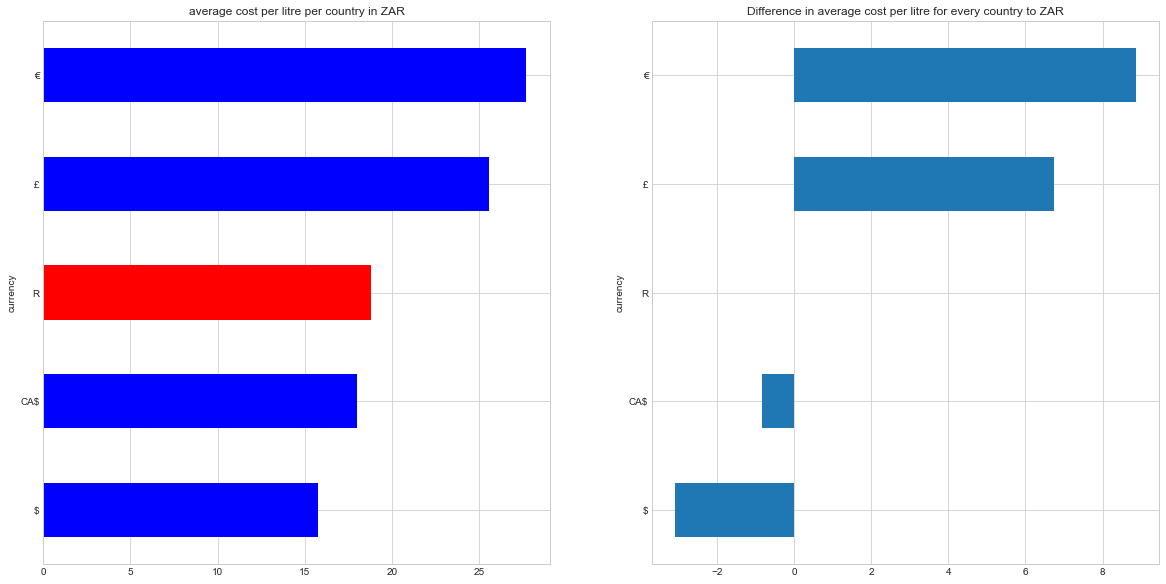

In [78]:
# Question 4.2.1.

ace = {'$' :15.4912,
        '£' :21.0078,
        '€' :17.5419,
        'CA$' :12.2773,
        'R' :1} # The currency conversions for Jan, 2022

def toZAR(val, curr):
        if curr in ace:
                return val * ace[curr]
        else:
                return np.nan

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,10))
# print(top5_currency_df.head())

top5_currency_df['cost_per_litre_ZAR'] = top5_currency_df.apply(lambda x: toZAR(x['cost_per_litre'], x['currency']), axis=1) #apply the conversion to the cost_per_litre to get all the prices in rands
filtered_df = top5_currency_df.loc[(top5_currency_df['date_fueled'] >= '2022-01-01') & (top5_currency_df['date_fueled'] < '2022-02-01')] #filter the date so that it is just for january
data = filtered_df.groupby(by = 'currency',as_index=True)['cost_per_litre_ZAR'].mean().sort_values() #group by the currency and get the average of the cost per gallon for every currency
data = data.dropna() #drop the null values
colors = np.where(data.index.isin(['R']), 'red', 'blue')
data.plot(ax = axes[0],kind = 'barh',color = colors).set_title('average cost per litre per country in ZAR')
# print(data.head())

#do plot that compares the average price per litre of every countrie to south africa 
zar = data['R']
diff = data - zar
diff.plot(ax =axes[1],kind = 'barh').set_title('Difference in average cost per litre for every country to ZAR')
fig.show()

top5_currency_df.drop(['cost_per_litre_ZAR'], inplace=True, axis=1)


Euros and Pounds have a much higher average cost per litre. This is likely due to the following factors: The Rand being weak against these currencies, they may have higher import taxes on natural resources,there being access to natural resources in the North American countires whereas the European countries do not have local access to oil and higher taxes imposed on fossil fuels (non-renewable forms of fuel) in these countries.

References:
- [for AUD, USD, CAD, UK pound, Euro](https://www.sars.gov.za/wp-content/uploads/Legal/Rates/LAPD-Pub-AER-2012-03-Average-Exchange-Rates-Table-B.pdf)


### Question 4.2.2.
Rule: If the miles per gallon changes by more than 40% between two entries, there was likely a missing entry.

In [79]:
dfCopy = top5_currency_df.copy()

dfCopy.sort_values(by=['user_id'])
dfCopy['delta'] = dfCopy.groupby(['user_id'])['mpg'].diff()

print("Percentage of incorrect entries:",len(dfCopy[dfCopy.delta/dfCopy.mpg > 0.4])/len(dfCopy) * 100, '%')

Percentage of incorrect entries: 7.931277281824306 %


          litres            km  km_per_tank
currency                                   
£          82394  4.285278e+07   520.095852
€          56245  2.886585e+07   513.216362
R          34261  1.666016e+07   486.271739
$         702075  2.916981e+08   415.479913
CA$        43906  1.786146e+07   406.811425


Text(0.5, 0, 'km_per_tank')

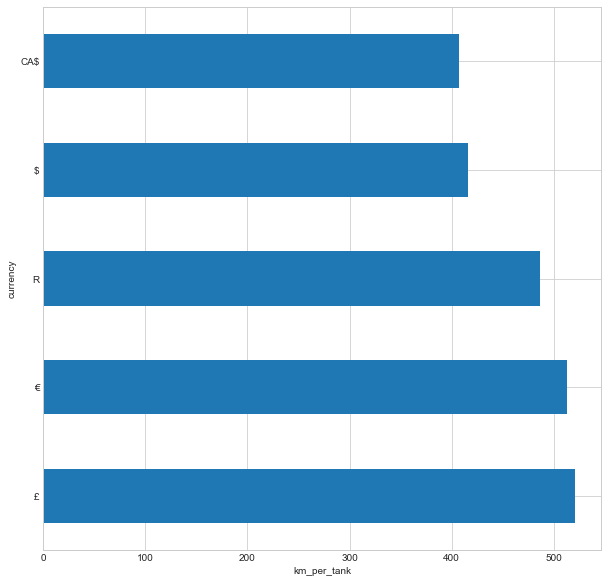

In [80]:
# Question 4.2.3.

#if we use a fill up as a proxy for tank

tanks_per_country = top5_currency_df.groupby('currency').agg({'litres': pd.Series.count})
km_per_country = top5_currency_df.groupby('currency').agg({'km': pd.Series.sum})

data = pd.concat([tanks_per_country,km_per_country], axis =1)
data['km_per_tank'] = data['km']/data['litres']
data = data.sort_values(by = 'km_per_tank',ascending=False)

print(data.head(5))
data['km_per_tank'].plot(kind = 'barh',figsize = (10,10)).set_xlabel('km_per_tank')


The U.K. has the largest average distance. This may be the case due to the fact that people in the U.K. are more likely to live further from city centers due to high housing costs. Therefore, they are more likely to commute into the city for work, which is more fuel efficient than stop-start driving in the city and, thus, drive further between fill-ups. They are also more likely to drive smaller, fuel efficient cars to drive through the city. The reference below states that the most popular car make driven from the end of 2020 was a Ford, which, from the graphs plotted below, is considered to be one of the fuel-efficient car brands.

References:
- [U.K. Transportation FAQs](https://www.racfoundation.org/motoring-faqs/mobility#a3)


      year          km
90  2022.0  426.714376
89  2021.0  454.414199
88  2020.0  453.510848
87  2019.0  451.914088
86  2018.0  452.072156
..     ...         ...
4   1928.0  176.009770
3   1927.0   71.244556
2   1923.0   75.214510
1   1921.0    0.000000
0   1918.0  110.773055

[91 rows x 2 columns]


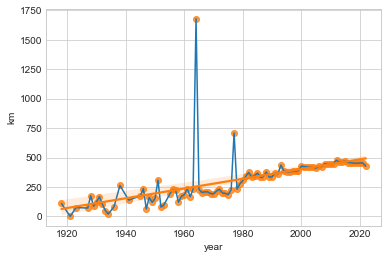

In [81]:
# Question 4.2.4.

data = top5_currency_df.groupby(by = 'year',as_index=False).agg({'km': pd.Series.mean}).sort_values(by= "year",ascending=False)
print(data)
v = sns.lineplot(x = data['year'], y = data['km'])
v = sns.regplot(x = data['year'], y = data['km'])

### Question 4.2.4.
Looking at the graph above(ignoring outliers), we can see that newer cars do drive further distances between fill-ups.

In [82]:
# Question 4.2.5.

sa_df = top5_currency_df[top5_currency_df['currency'].isin(['R'])] #get SA entries
car_model_counts = sa_df['car_model'].value_counts().head(5)

def convert_to_kpl(mpg):
    if mpg != np.nan:
        return mpg * 0.425143707

#doing it for car model
#get top 5 cars as list
car_model_list = list(car_model_counts.index)
sa_model_df = sa_df[sa_df['car_model'].isin(car_model_list)]
data = sa_model_df.groupby('car_model').agg({'mpg': pd.Series.mean})
data['kmL'] = data.apply(lambda x: convert_to_kpl(x['mpg']), axis=1)
print(data.head())


                 mpg        kmL
car_model                      
fortuner   18.499419   7.864911
hilux      17.953261   7.632716
jimny      22.630556   9.621238
pajero     15.491968   6.586313
polo       28.024204  11.914314


These values are realistic, however the Fortuner has a lower than expected kmL.

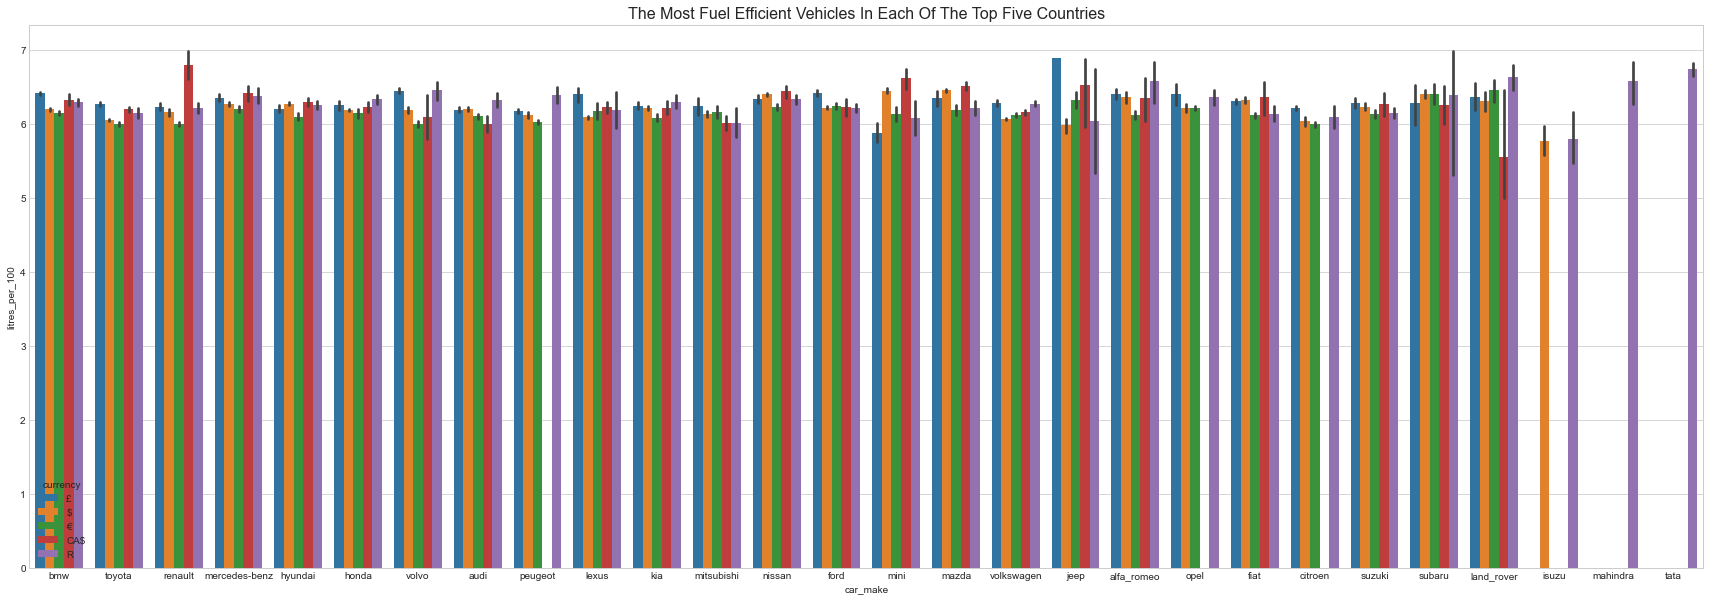

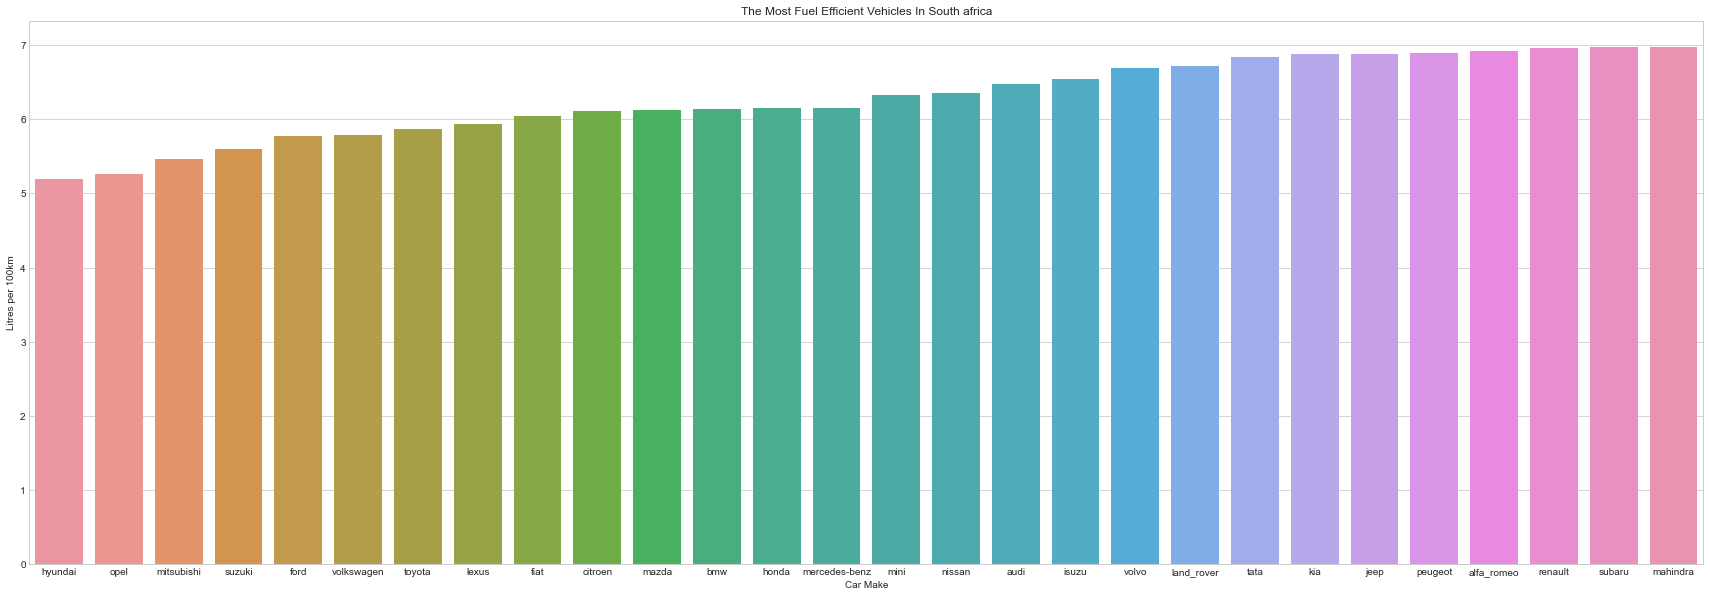

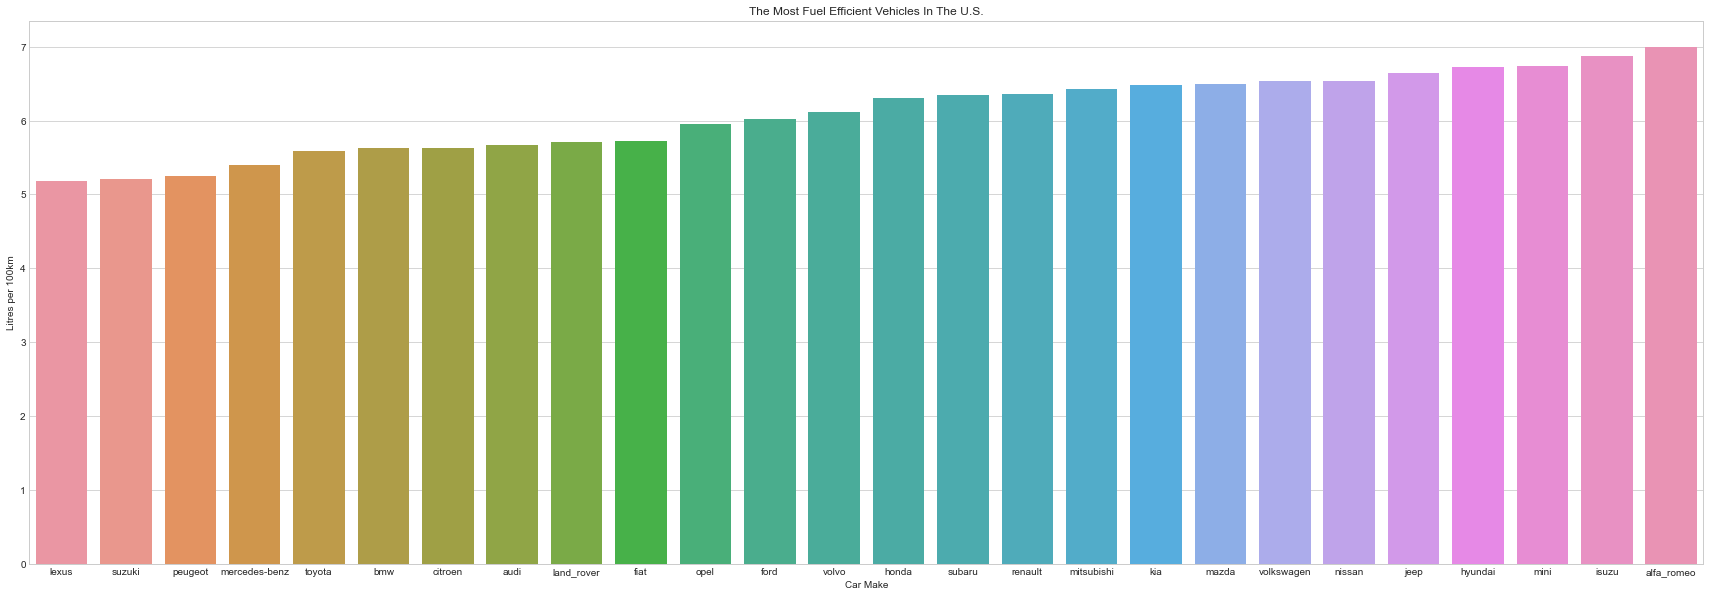

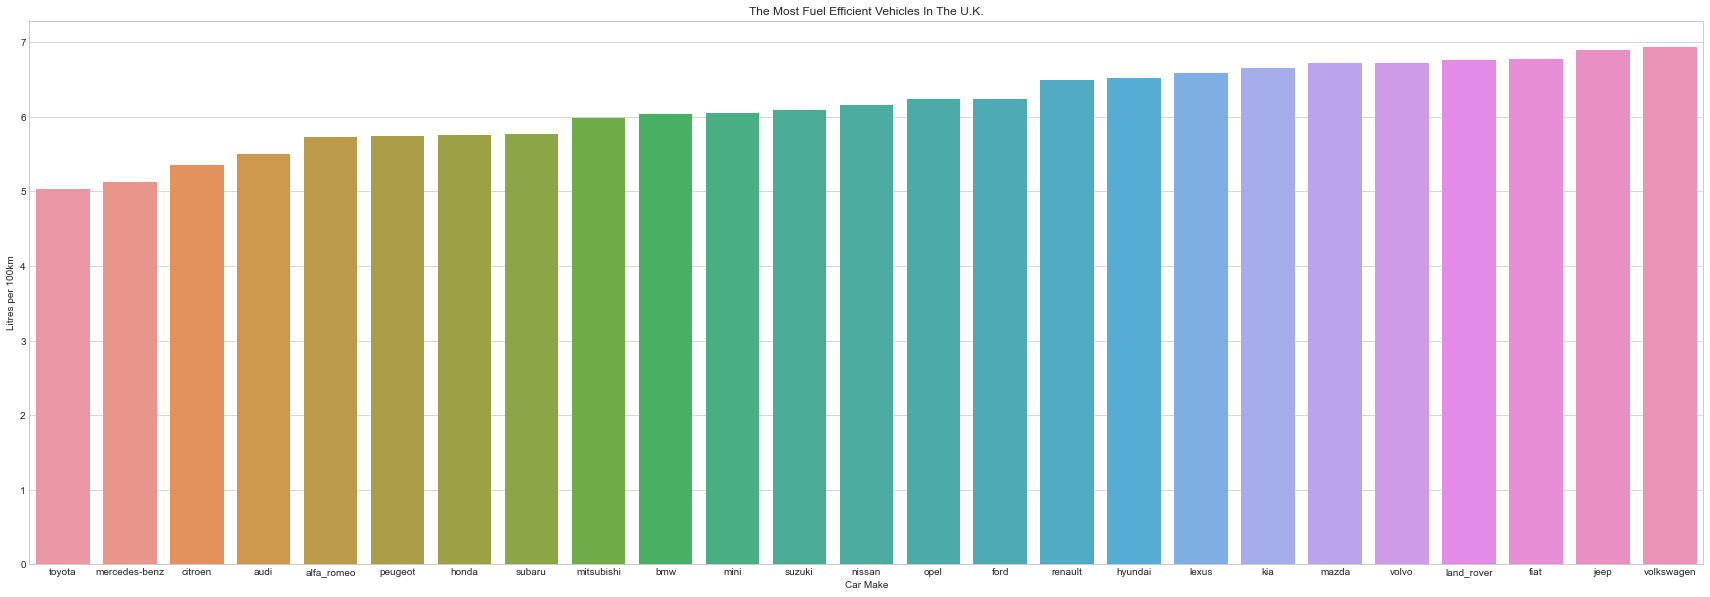

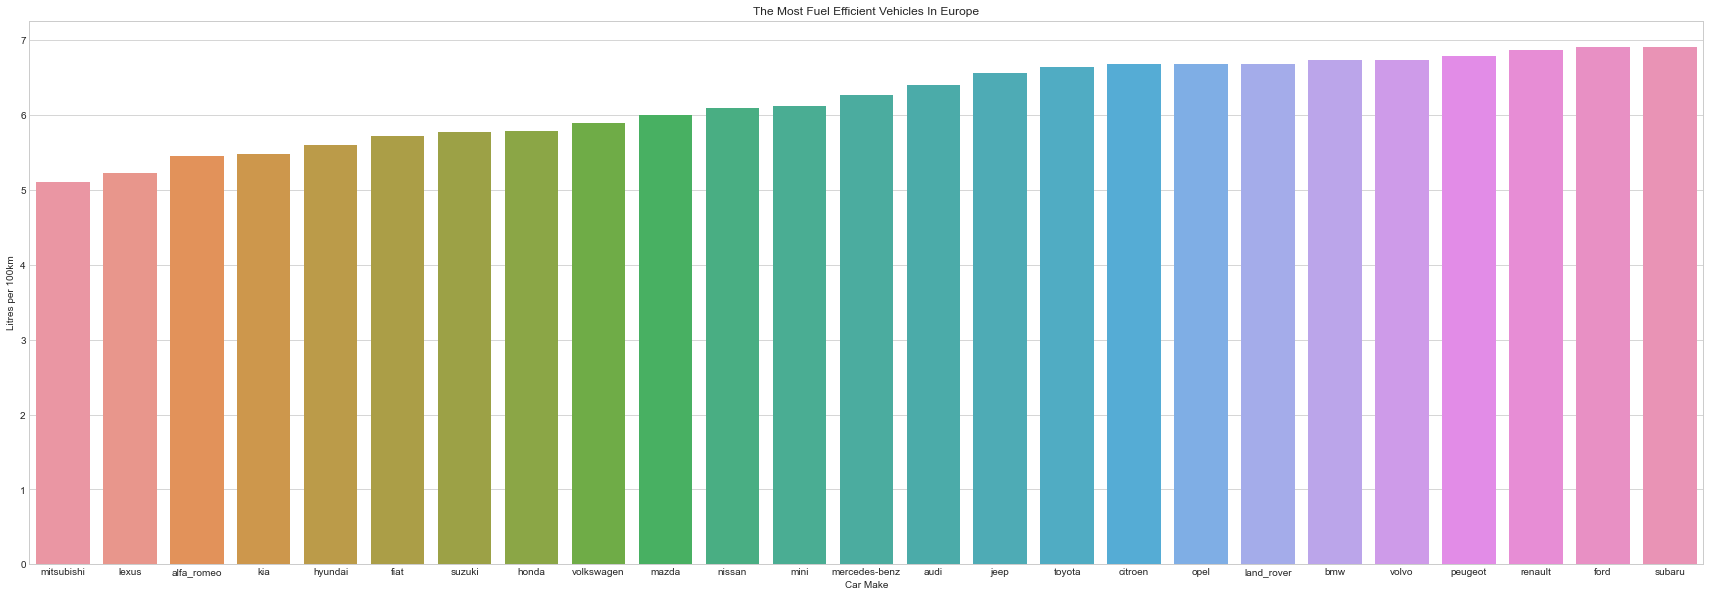

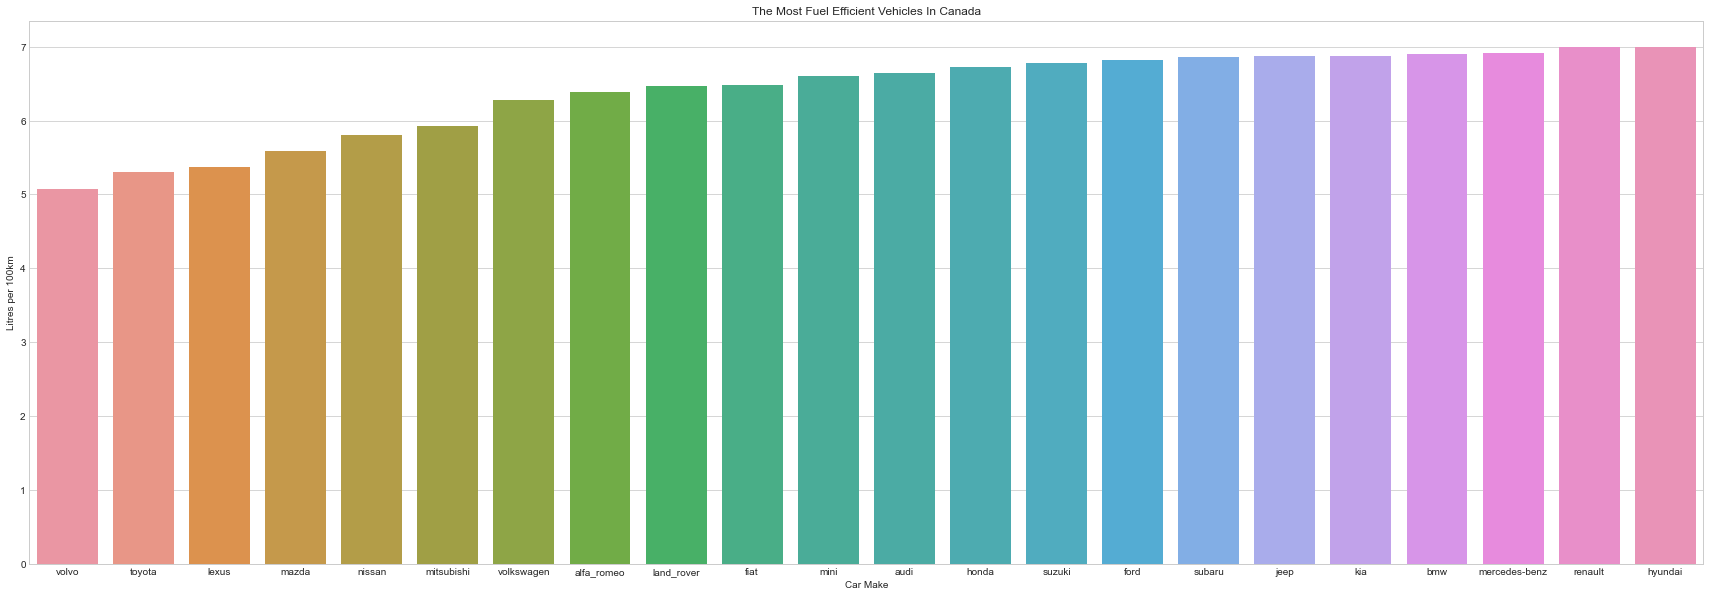

In [83]:
# Question 4.2.6.

# Considering between 5 and 7 litres to be an efficient amount per 100 km.
df_efficiency = top5_currency_df[(top5_currency_df['litres_per_100'] >= 5) & (top5_currency_df['litres_per_100'] <= 7)]
fig, axs = plt.subplots(figsize=(30, 10))
sns.barplot(y='litres_per_100',x='car_make',hue='currency',data=df_efficiency)
plt.title("The Most Fuel Efficient Vehicles In Each Of The Top Five Countries",fontsize= 16)
plt.show()

def efficiency_plot(df, country):
    data = df.groupby(by='car_make', as_index=False).agg({'litres_per_100': 'first'}).sort_values('litres_per_100')
    # data['car_make'] = np.where(data['litres_per_100'] >= np.min(data['litres_per_100']), data['car_make'], "Other")

    # Dropping other as its not relevant for this question
    data = data[data.car_make != "Other"]

    fig, axs = plt.subplots(figsize=(30, 10))
    sns.barplot(x=data['car_make'], y=data['litres_per_100']).set(xlabel="Car Make", ylabel="Litres per 100km", title="The Most Fuel Efficient Vehicles In {}".format(country))
    plt.show()



# Plotting the most fuel efficient vehicles for each of the top 5 currencies:
# South Africa:
df_rand = df_efficiency[df_efficiency['currency'].isin(['R'])] 
efficiency_plot(df_rand, "South africa")

# U.S.:
df_dollar = df_efficiency[df_efficiency['currency'].isin(['$'])] 
efficiency_plot(df_dollar, "The U.S.")

# U.K.:
df_pound = df_efficiency[df_efficiency['currency'].isin(['£'])] 
efficiency_plot(df_pound, "The U.K.")

# Europe:
df_euro = df_efficiency[df_efficiency['currency'].isin(['€'])] 
efficiency_plot(df_euro, "Europe")

# Canada:
df_ca = df_efficiency[df_efficiency['currency'].isin(['CA$'])] 
efficiency_plot(df_ca, "Canada")



### Question 4.2.6.
We have considered between 5 and 7 litres to be an efficient amount per 100 kilmeteres driven. Based on the plots above, the table below shows the top five most fuel-efficient vehicles from each of the five countries.
<style>
th {
  padding-top: 5px;
  padding-right: 10px;
  padding-bottom: 5px;
  padding-left: 10px;
}
</style>

| Country | Most Fuel Efficient |  2nd Most Fuel Efficient |  3rd Most Fuel Efficient |  4th Most Fuel Efficient |  5th Most Fuel Efficient |
| :------------: | :-------:  | :-------:  | :-------:  | :-------:  | :-------:  |
| South Africa | Hyundai | Opel | Mitsubishi | Suzuki | Ford |
| The U.S. | Lexus | Volkswagen | Tata | Peugeot | Mercedes-Benz |
| Europe | Toyota | Mercedes-Benz | Citroen | Audi | Alpha Romeo |
| The U.K.| Mitsubishi | Lexus | Alpha Romeo | Kia | Hyundai |
| Canada| Volvo | Toyota | Lexus | Mazda | Nissan |

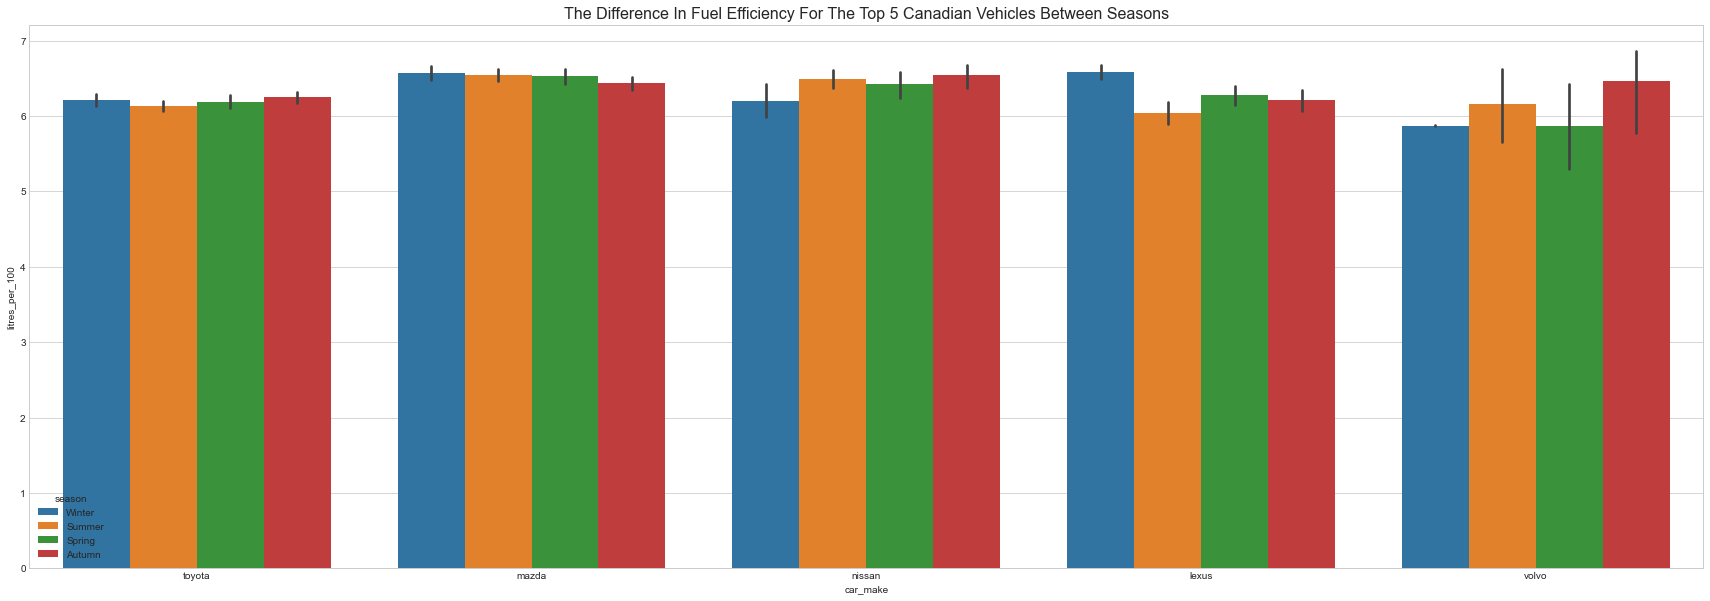

In [84]:
# Question 4.2.7.

# Top 5 most efficient vehicles: volvo, toyota, lexus, mazda, nissan

# Extract the month out of the date_fueled column:
df_ca['month'] = pd.DatetimeIndex(df_ca['date_fueled']).month

# In Canada, the seasons fall into the following months:
# 1. Winter – December, January and February.
# 2. Spring – March, April and May.
# 3. Summer – June, July and August.
# 4. Autumn – September, October and November.

def seasons(month_num):
	if ((month_num == 12) | (month_num == 1) | (month_num == 2)):
		return "Winter"
	elif ((month_num == 3) | (month_num == 4) | (month_num == 5)):
		return "Spring"
	elif ((month_num == 6) | (month_num == 7) | (month_num == 8)):
		return "Summer"
	elif ((month_num == 9) | (month_num == 10) | (month_num == 11)):
		return "Autumn"
	else:
		return "N/A"

df_ca['season'] = df_ca.apply(lambda x: seasons(x['month']),axis=1)

top5_cars_ca = df_ca[df_ca['car_make'].isin(['volvo', 'toyota', 'lexus', 'mazda', 'nissan'])]

# Plotting:
fig, axs = plt.subplots(figsize=(30, 10))
pl = sns.barplot(y='litres_per_100',x='car_make',hue='season',data=top5_cars_ca)
plt.title("The Difference In Fuel Efficiency For The Top 5 Canadian Vehicles Between Seasons",fontsize= 16)
plt.show()


### Question 4.2.7.
The general rule for fuel efficiency can be stated as: the lower the amount of fuel consumed per 100 kilometers, the more fuel efficient the vehicle.
We would expect to see quite big differences in the fuel efficiency of the vehicle depending on the season due to the diverse weather conditions in Canada. In winter, Canadian drivers can expect snowy conditions, which means that the engin will take longer to warm up and reach its most fuel-efficient temperature, whereas in summer, the warmer temperatures will result in the engin of the vehicle reaching its optimal temperature sooner, resulting in better fuel efficiency. From the plot above, we can see that this happens to be the case for all Lexus vehicles. Nissan and Volvo cars also experience significant differences in fuel efficiency depending on the season, however, these differences are the inverse of what is experienced by Lexus vehicles. All Toyota and Mazda models do not have large differences in vehicle efficiency based on the seasons - they remain at similar fuel-efficient levels throughout the year.

date_fueled         0.005419
date_captured       0.002391
odometer           -0.019751
gallons            -0.000459
cost_per_gallon     0.001785
total_spent         0.019443
mpg                 1.000000
miles               0.188465
user_url           -0.002014
currency            0.037083
car_make            0.020142
car_model           0.022275
year               -0.004864
user_id            -0.002496
litres              0.026692
km                  0.188756
litres_per_100      0.135129
cost_per_litre      0.008201
cost_per_litre_R    0.010179
total_spent_R       0.056251
kmL                 1.000000
Name: mpg, dtype: float64


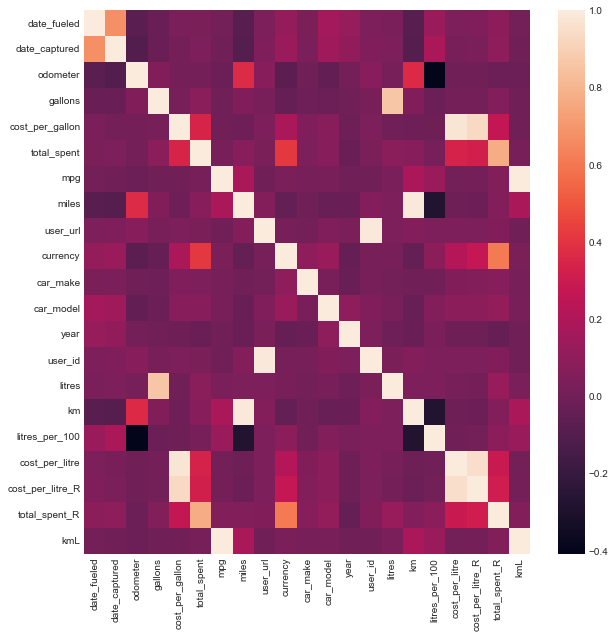

In [96]:
# Question 4.2.8.

fig, ax = plt.subplots(figsize=(10,10))
top5_currency_df['kmL'] = top5_currency_df.apply(lambda x : convert_to_kpl(x['mpg']),axis=1)
correlations = top5_currency_df.apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(correlations,ax=ax)

print(correlations['mpg'])

           Features  Importances
4           user_id     0.045037
5    cost_per_litre     0.060990
0          odometer     0.070651
1          car_make     0.111010
6  cost_per_litre_R     0.119334
3              year     0.123751
7     total_spent_R     0.174077
2         car_model     0.295150


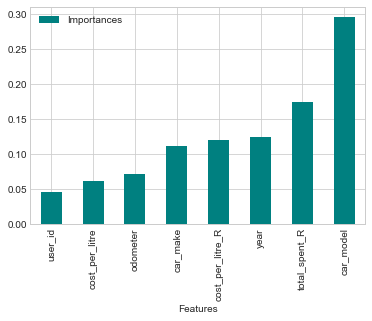

In [86]:
# Question 4.2.9.

le = LabelEncoder()
dfCopy = top5_currency_df.drop(columns=['date_fueled','date_captured','user_url','currency','gallons','cost_per_gallon','total_spent','miles','mpg','litres_per_100','km','litres'])
dfCopy['car_make'] =le.fit_transform(dfCopy['car_make'])
dfCopy['car_model'] =le.fit_transform(dfCopy['car_model'])
dfCopy.replace([np.inf , -np.inf], np.nan, inplace=True)
dfCopy.fillna(dfCopy.mean(),inplace=True)
model = RandomForestRegressor(n_estimators= 100, random_state=42, max_depth =10) 
X = dfCopy.drop(columns=['kmL'])
y = dfCopy['kmL']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
model.fit(X_train,y_train)
importances = model.feature_importances_
final_df = pd.DataFrame({ "Features": pd.DataFrame(X_train).columns, "Importances": importances})
final_df.set_index('Importances')
final_df = final_df.sort_values('Importances')
final_df.plot.bar(color ='teal', x = 'Features')
print(final_df)

The top three most important variables are *car_model*, *total_spent_R* and *year*. These are reasonable features, however, they slightly differ from the heatmap above, which may be due to the fact that different measures are used in the relevant calculations.

## 4.3. Fuel Usage in SA

In [87]:
# Question 4.3.1.

df_sa = top5_currency_df[top5_currency_df['currency'] == 'R']
print(df_sa.head())

    date_fueled date_captured  odometer  gallons  cost_per_gallon  \
98   2022-04-05    2022-04-05   78429.0   10.567            73.85   
100  2013-06-06    2013-06-08       NaN   17.937            47.05   
197  2019-01-23    2019-02-01  169070.0   22.011            54.59   
323  2018-08-12    2019-08-04   41111.0    6.763            60.19   
334  2016-06-16    2016-06-16    2430.0   18.011            48.45   

     total_spent   mpg     miles  \
98        780.40   0.0    0.0000   
100       843.99  23.3  418.4000   
197      1201.47   0.0    0.0000   
323       407.04  40.7  275.2541   
334       872.69  15.5  279.1705   

                                              user_url currency  ...  \
98   https://www.somewebsite.com/ford/transit_conne...        R  ...   
100  https://www.somewebsite.com/land_rover/discove...        R  ...   
197  https://www.somewebsite.com/nissan/patrol/1999...        R  ...   
323  https://www.somewebsite.com/ford/ecosport/2013...        R  ...   
334  htt

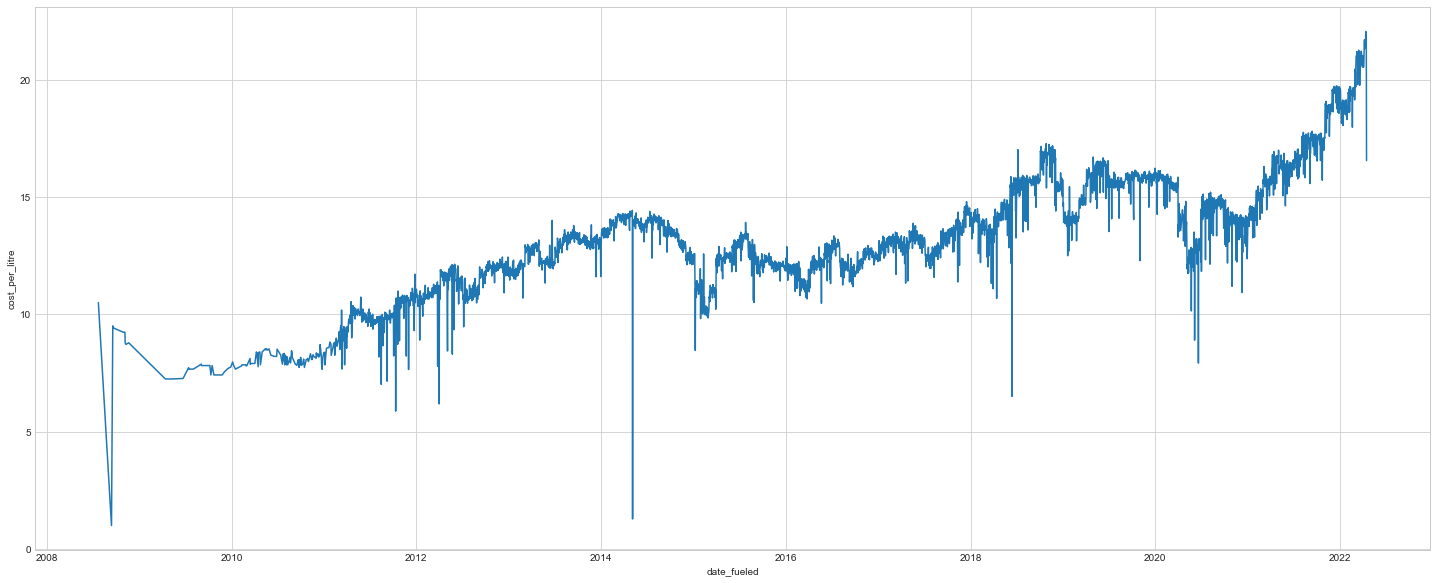

In [88]:
# Question 4.3.2.

data = df_sa.groupby('date_fueled',as_index = False).agg({'cost_per_litre':pd.Series.mean}).sort_values(by = 'date_fueled')
fig, axs = plt.subplots(figsize=(25, 10))

sns.lineplot(x = data['date_fueled'] ,y=data['cost_per_litre'])
plt.show()

In [89]:
# Question 4.3.3.

def convert_day(digit):
    if digit == 0:
        return 'Monday'
    if digit == 1:
        return 'Tuesday'
    if digit == 2:
        return 'Wednesday'
    if digit == 3:
        return 'Thursday'
    if digit == 4:
        return 'Friday'
    if digit == 5:
        return 'Saturday'
    if digit == 6:
        return 'Sunday'

df_sa['day_of_week'] = df_sa['date_fueled'].dt.weekday
df_sa['day_of_week'] = df_sa.apply(lambda x: convert_day(x['day_of_week']),axis=1)

print(df_sa.head())

    date_fueled date_captured  odometer  gallons  cost_per_gallon  \
98   2022-04-05    2022-04-05   78429.0   10.567            73.85   
100  2013-06-06    2013-06-08       NaN   17.937            47.05   
197  2019-01-23    2019-02-01  169070.0   22.011            54.59   
323  2018-08-12    2019-08-04   41111.0    6.763            60.19   
334  2016-06-16    2016-06-16    2430.0   18.011            48.45   

     total_spent   mpg     miles  \
98        780.40   0.0    0.0000   
100       843.99  23.3  418.4000   
197      1201.47   0.0    0.0000   
323       407.04  40.7  275.2541   
334       872.69  15.5  279.1705   

                                              user_url currency  ...    year  \
98   https://www.somewebsite.com/ford/transit_conne...        R  ...  2015.0   
100  https://www.somewebsite.com/land_rover/discove...        R  ...  1996.0   
197  https://www.somewebsite.com/nissan/patrol/1999...        R  ...  1999.0   
323  https://www.somewebsite.com/ford/ecosport/2

<AxesSubplot:xlabel='day_of_week'>

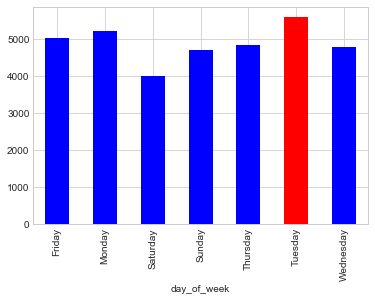

In [90]:
# Question 4.3.4.

data = df_sa.groupby(by= 'day_of_week')['user_url'].count()
colors = np.where(data.index.isin(['Tuesday']), 'red', 'blue')
data.plot(kind = 'bar',color = colors)

In [91]:
# Question 4.3.5.

df_first_TW = df_sa[((df_sa['day_of_week'] == 'Tuesday') | (df_sa['day_of_week'] == 'Wednesday')) & (df_sa['date_fueled'].dt.day < 8)]
df_first_TW = df_first_TW.groupby(by='date_fueled',as_index = False).agg({'cost_per_litre': pd.Series.mean, 'day_of_week': 'first'}).sort_values(by = 'date_fueled').reset_index()
print(df_first_TW.head(20))

    index date_fueled  cost_per_litre day_of_week
0       0  2008-11-04        9.241744     Tuesday
1       1  2008-11-05        8.789960   Wednesday
2       2  2009-09-02        7.881110   Wednesday
3       3  2009-10-06        7.820343     Tuesday
4       4  2009-11-04        7.421400   Wednesday
5       5  2010-06-02        8.346103   Wednesday
6       6  2010-12-01        8.361955   Wednesday
7       7  2011-01-04        7.852048     Tuesday
8       8  2011-03-01        9.261118     Tuesday
9       9  2011-04-05        9.250550     Tuesday
10     10  2011-05-03        9.801849     Tuesday
11     11  2011-05-04       10.031704   Wednesday
12     12  2011-06-01       10.030383   Wednesday
13     13  2011-06-07        9.812417     Tuesday
14     14  2011-07-05        9.490092     Tuesday
15     15  2011-07-06        9.949802   Wednesday
16     16  2011-08-02        9.744606     Tuesday
17     17  2011-08-03        9.896962   Wednesday
18     18  2011-09-06        9.791281     Tuesday


In [92]:
# Question 4.3.6.

# Indicator function determines if there was a price increase or price decrease:
def indicator(inp, day_diff):
    if (inp < 0) & (day_diff == True):
        return "Decrease"
    elif (inp > 0) & (day_diff == True):
        return "Increase"
    elif (inp == 0) & (day_diff == True):
        return "No Change"

    elif day_diff == False:
        return "Not Applicable"

    elif np.isnan(inp):
        return "Not Applicable" 

# Creating a new column that will only consider the year-month combination:
df_first_TW['ym-date'] = df_first_TW['date_fueled'].dt.strftime('%Y-%m')

# Removing all unique rows as we can only compare rows with consecutive months:
df_first_TW = df_first_TW[df_first_TW['ym-date'].duplicated(keep = False)]


# Calculating the price change using cost_per_litre:
df_first_TW['price_change'] = df_first_TW['cost_per_litre'].diff(periods=1)

# Creating a new column that will output 'True' if there is a less than 35 day diference between the two consecutive dates
# and 'False' if there are more than 35 days between the dates. This is needed so that we are able to see whether there 
# was a price increase or decrease on the first Tuesday of the month and we can only do this using data from the previous month.
df_first_TW['day_diff'] = df_first_TW['date_fueled'].diff()<=pd.Timedelta(35,'d')

df_first_TW['price_change'] = df_first_TW.apply(lambda x: indicator(x['price_change'], x['day_diff']),axis=1)

print(df_first_TW.head(20))
print("Number of records:")
print(len(df_first_TW))

    index date_fueled  cost_per_litre day_of_week  ym-date    price_change  \
0       0  2008-11-04        9.241744     Tuesday  2008-11  Not Applicable   
1       1  2008-11-05        8.789960   Wednesday  2008-11        Decrease   
10     10  2011-05-03        9.801849     Tuesday  2011-05  Not Applicable   
11     11  2011-05-04       10.031704   Wednesday  2011-05        Increase   
12     12  2011-06-01       10.030383   Wednesday  2011-06        Decrease   
13     13  2011-06-07        9.812417     Tuesday  2011-06        Decrease   
14     14  2011-07-05        9.490092     Tuesday  2011-07        Decrease   
15     15  2011-07-06        9.949802   Wednesday  2011-07        Increase   
16     16  2011-08-02        9.744606     Tuesday  2011-08        Decrease   
17     17  2011-08-03        9.896962   Wednesday  2011-08        Increase   
18     18  2011-09-06        9.791281     Tuesday  2011-09        Decrease   
19     19  2011-09-07        7.154557   Wednesday  2011-09      

    index date_fueled  cost_per_litre day_of_week  ym-date price_change  \
1       1  2008-11-05        8.789960   Wednesday  2008-11     Decrease   
11     11  2011-05-04       10.031704   Wednesday  2011-05     Increase   
12     12  2011-06-01       10.030383   Wednesday  2011-06     Decrease   
15     15  2011-07-06        9.949802   Wednesday  2011-07     Increase   
17     17  2011-08-03        9.896962   Wednesday  2011-08     Increase   

    day_diff  
1       True  
11      True  
12      True  
15      True  
17      True  
day_of_week  price_change
Wednesday    Decrease        50
             Increase        80
Name: day_of_week, dtype: int64


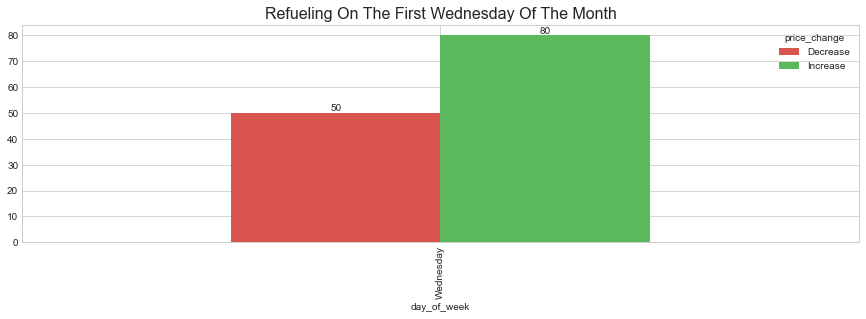

In [93]:
# Question 4.3.7.

df_wed = df_first_TW[df_first_TW['day_of_week'] == 'Wednesday']
print(df_wed.head())

data_group = df_wed.groupby(["day_of_week", "price_change"])['day_of_week'].count()
print(data_group)

# Plotting:
color_list = ['#d9534f', '#5cb85c', '#5bc0de',]
ax = pd.crosstab(df_wed['day_of_week'],df_wed['price_change']).plot.bar(figsize=(15,4), color=color_list)
plt.title("Refueling On The First Wednesday Of The Month",fontsize= 16)

for p in ax.containers:
    ax.bar_label(p, label_type='edge')

### Question 4.3.7. 
Based on the bar plot above, it can be seen that fewer people refuel on the first Wednesday of the month when the prices goes down. From the 130 people that refueled, only 50 people (38%) refueled when there was a price decrease, while 62% of people refueled on the first Wednesday of the month when the prices went up.

    index date_fueled  cost_per_litre day_of_week  ym-date    price_change  \
0       0  2008-11-04        9.241744     Tuesday  2008-11  Not Applicable   
10     10  2011-05-03        9.801849     Tuesday  2011-05  Not Applicable   
13     13  2011-06-07        9.812417     Tuesday  2011-06        Decrease   
14     14  2011-07-05        9.490092     Tuesday  2011-07        Decrease   
16     16  2011-08-02        9.744606     Tuesday  2011-08        Decrease   

    day_diff  
0      False  
10     False  
13      True  
14      True  
16      True  
day_of_week  price_change  
Tuesday      Decrease          67
             Increase          58
             Not Applicable     5
Name: day_of_week, dtype: int64


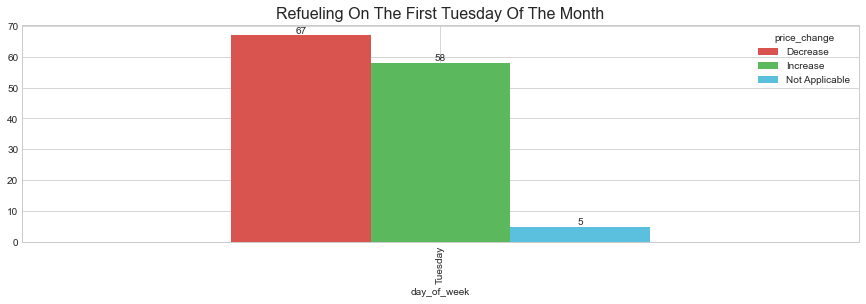

In [94]:
# Question 4.3.8.

df_tues = df_first_TW[df_first_TW['day_of_week'] == 'Tuesday']
print(df_tues.head())

data_group = df_tues.groupby(["day_of_week", "price_change"])['day_of_week'].count()
print(data_group)

# Plotting:
color_list = ['#d9534f', '#5cb85c', '#5bc0de',]
ax = pd.crosstab(df_tues['day_of_week'],df_tues['price_change']).plot.bar(figsize=(15,4), color=color_list)
plt.title("Refueling On The First Tuesday Of The Month",fontsize= 16)

for p in ax.containers:
    ax.bar_label(p, label_type='edge')


### Question 4.3.8.
Based on the bar plot above, it can be seen that fewer people refuel on the first Tuesday of the month when the prices goes up. While 58 out of 130 people (44.61%) refuel on the first Tuesday of the month when there is a price increase, 67 out of 130 people (51.54%) refuel when there is a price decrease. Therefore, there is a 6.92% difference in the amount of people that fill up when there is a price increase compared to when there is a price decrease. In addition to this, 5 out of the 130 records (3.85%) are classified as 'Not Applicable'. This is because there were no previous months to compare the relevent record to, hence it was impossible to determine whether there was a price increase or price decrease on the first Tuesday of that month.